## 探索数据

### 导入数据
通过 Pandas 库从数据集文件分别导入数据至 `data_train`、`data_test` 和 `data_store` 三个数据帧（_DataFrame_），即训练集、测试集和商店补充数据集。

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

% matplotlib inline

sns.set(style='whitegrid', palette='muted')

data_train = pd.read_csv('data/train.csv',
                         dtype={
                             'StateHoliday': 'category',
                             'SchoolHoliday': 'category'},
                         parse_dates=['Date'])
data_test = pd.read_csv('data/test.csv',
                        dtype={
                            'StateHoliday': 'category',
                            'SchoolHoliday': 'category'},
                        parse_dates=['Date'])
data_store = pd.read_csv('data/store.csv',
                         dtype={
                             'StoreType': 'category',
                             'Assortment': 'category',
                             'CompetitionOpenSinceMonth': float,
                             'CompetitionOpenSinceYear': float,
                             'Promo2': float,
                             'Promo2SinceWeek': float,
                             'Promo2SinceYear': float})

### 检查数据

为方便分析，通过 _Store_ 字段索引联合合并 `data_train` 与 `data_store` 数据集到同一数据集中。合并后的 `data_train` 包含原有字段以及对应的商店信息。

In [3]:
data_train = pd.merge(data_train, data_store, on='Store', how='left')
data_train.head(5)

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0.0,NaN,NaN,NaN
1,2,5,2015-07-31,6064,625,1,1,0,1,a,a,570.0,11.0,2007.0,1.0,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,5,2015-07-31,8314,821,1,1,0,1,a,a,14130.0,12.0,2006.0,1.0,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,c,620.0,9.0,2009.0,0.0,NaN,NaN,NaN
4,5,5,2015-07-31,4822,559,1,1,0,1,a,a,29910.0,4.0,2015.0,0.0,NaN,NaN,NaN


#### 缺失值和异常值
输出并观察训练集 `data_train` 的基本信息和统计量：

In [4]:
print('Total number of samples:', data_train.shape[0])
print('')
data_train.info()
print('')
print(data_train.iloc[:, 1:].describe())

Total number of samples: 1017209

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1017209 entries, 0 to 1017208
Data columns (total 18 columns):
Store                        1017209 non-null int64
DayOfWeek                    1017209 non-null int64
Date                         1017209 non-null datetime64[ns]
Sales                        1017209 non-null int64
Customers                    1017209 non-null int64
Open                         1017209 non-null int64
Promo                        1017209 non-null int64
StateHoliday                 1017209 non-null category
SchoolHoliday                1017209 non-null category
StoreType                    1017209 non-null category
Assortment                   1017209 non-null category
CompetitionDistance          1014567 non-null float64
CompetitionOpenSinceMonth    693861 non-null float64
CompetitionOpenSinceYear     693861 non-null float64
Promo2                       1017209 non-null float64
Promo2SinceWeek              509178 non-null f

Missing value counts:
Store                             0
DayOfWeek                         0
Date                              0
Sales                             0
Customers                         0
Open                              0
Promo                             0
StateHoliday                      0
SchoolHoliday                     0
StoreType                         0
Assortment                        0
CompetitionDistance            2642
CompetitionOpenSinceMonth    323348
CompetitionOpenSinceYear     323348
Promo2                            0
Promo2SinceWeek              508031
Promo2SinceYear              508031
PromoInterval                508031
dtype: int64


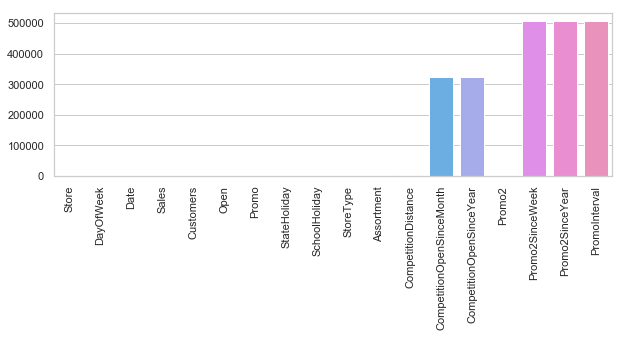

In [5]:
counts = data_train.isnull().sum()
print('Missing value counts:')
print(counts)
plt.figure(figsize=(10, 3))
g = sns.barplot(counts.index, counts.values)
g.set_xticklabels(g.get_xticklabels(), rotation=90)
plt.show()

训练集 `data_train` 共包含 1017209 个数据样本。若干字段存在数据缺失情况：_CompetitionDistance_, _CompetitionOpenSinceMonth_, _CompetitionOpenSinceYear_, _Promo2SinceWeek_, _Promo2SinceYear_ 和 _PromoInterval_。其中 _CompetitionDistance_ 为连续数值变量，可通过均值补全缺失数据。由于该项目将采用 XGBoost 构建模型，默认情况下 XGBoost 支持缺失值（树算法在训练期间学习缺失值的分叉方向），可令 XGBoost 自动处理其它分类变量的缺失数据。

绘制 _Sales_、_Customers_ 和 _CompetitionDistance_ 的频率直方图和箱线图：

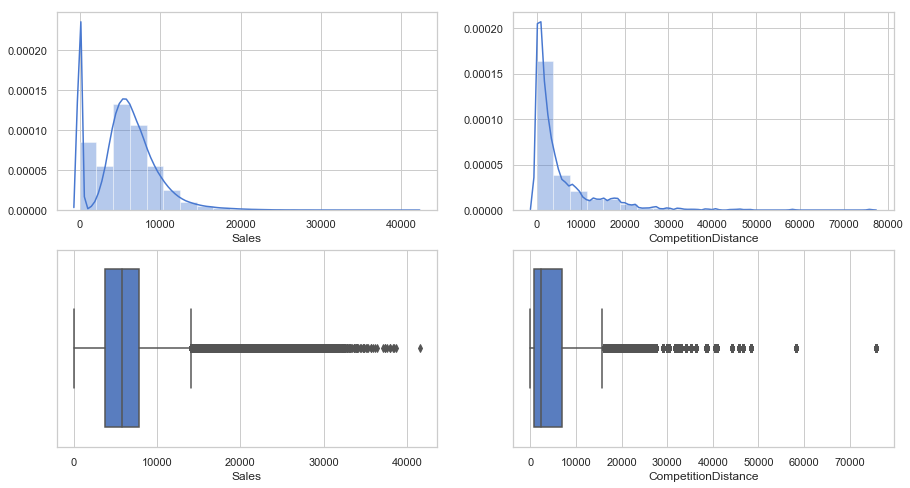

In [6]:
fig, axes = plt.subplots(2, 2, figsize=(15, 8))
sns.distplot(data_train['Sales'].dropna(), bins=20, ax=axes[0][0]);
sns.distplot(data_train['CompetitionDistance'].dropna(), bins=20, ax=axes[0][1]);
sns.boxplot(x=data_train['Sales'].dropna(), ax=axes[1][0])
sns.boxplot(x=data_train['CompetitionDistance'].dropna(), ax=axes[1][1])
plt.show()

从上图可发现在 _Sales_、_Customers_ 和 _CompetitionDistance_ 三个字段均存在异常值。 

### 可视化数据

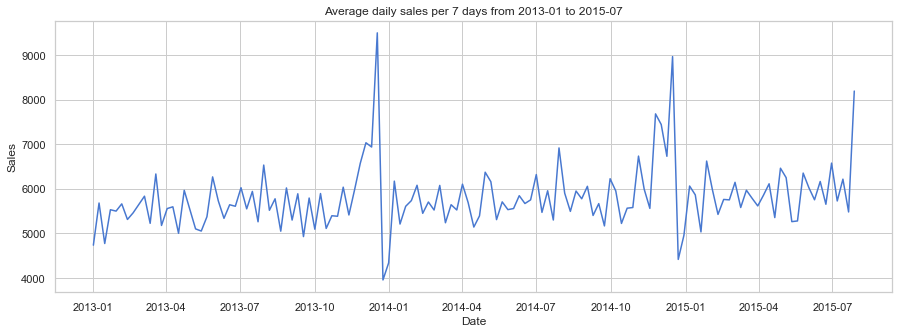

In [7]:
plt.figure(figsize=(15, 5))
data_train_sales = data_train[['Date', 'Sales']]
data_train_sales_1 = data_train_sales.groupby(pd.Grouper(key='Date', freq='7D')).mean()
ax = sns.lineplot(x=data_train_sales_1.index, y=data_train_sales_1['Sales'])
ax.set_title('Average daily sales per 7 days from 2013-01 to 2015-07')
plt.show()

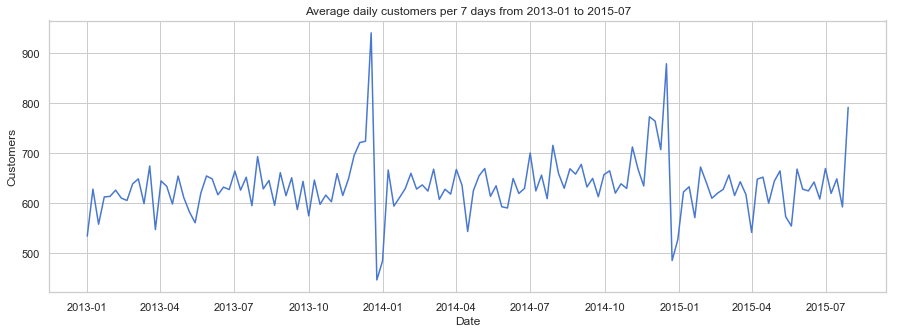

In [8]:
plt.figure(figsize=(15, 5))
data_train_customers = data_train[['Date', 'Customers']]
data_train_customers_1 = data_train_customers.groupby(pd.Grouper(key='Date', freq='7D')).mean()
ax = sns.lineplot(x=data_train_customers_1.index, y=data_train_customers_1['Customers'])
ax.set_title('Average daily customers per 7 days from 2013-01 to 2015-07')
plt.show()

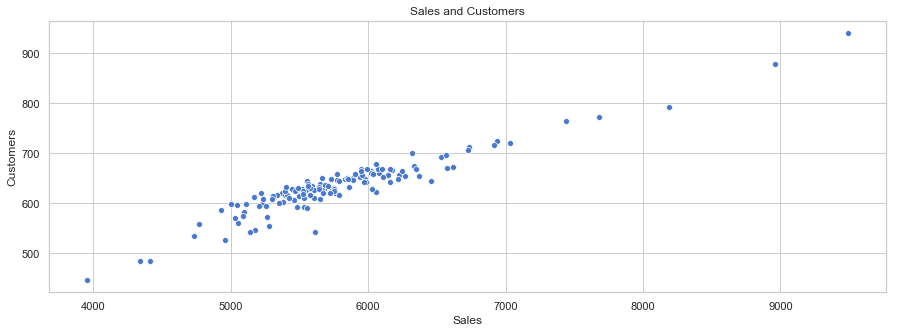

In [9]:
plt.figure(figsize=(15, 5))
sns.scatterplot(x=data_train_sales_1['Sales'], y=data_train_customers_1['Customers']).set_title('Sales and Customers')
plt.show()

In [10]:
data_train_open_sl_cstm = data_train[['Sales', 'Customers']]
data_train_open_sl_cstm.corr()

,Sales,Customers
Sales,1.000000,0.894711
Customers,0.894711,1.000000


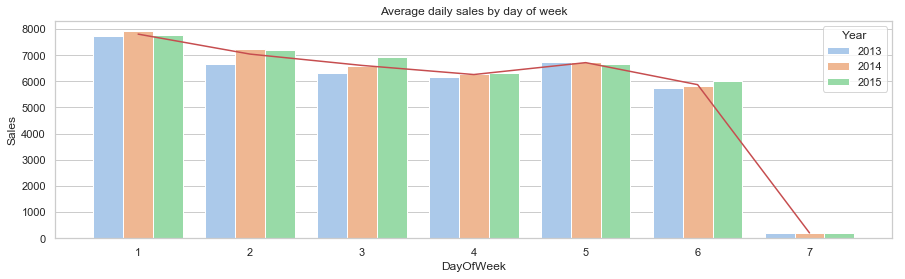

In [11]:
plt.figure(figsize=(15, 4))
data_train_wd = data_train.copy()
data_train_wd['Year'] = data_train_wd['Date'].dt.strftime('%Y')
data_train_wd = data_train_wd.groupby(['Year', 'DayOfWeek']).mean().reset_index()
sns.barplot(x='DayOfWeek', y='Sales', hue='Year', palette='pastel', data=data_train_wd)
data_train_wd = data_train_wd.groupby(['DayOfWeek']).mean().reset_index()
ax = sns.lineplot(x=data_train_wd.index, y=data_train_wd['Sales'], color='#c64d4f')
ax.set_title('Average daily sales by day of week')
ax.legend_.set_title('Year')
plt.show()

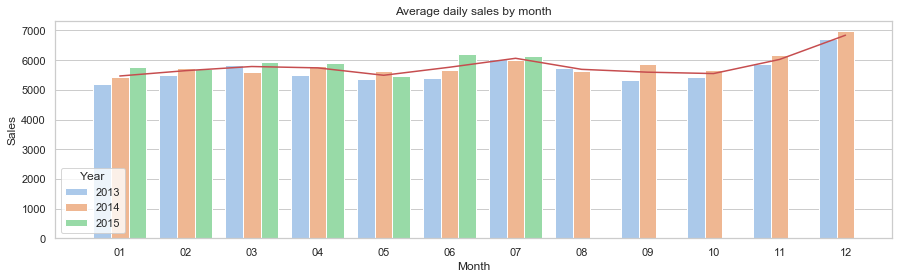

In [12]:
plt.figure(figsize=(15, 4))
data_train_m = data_train.copy()
data_train_m['Year'] = data_train_m['Date'].dt.strftime('%Y')
data_train_m['Month'] = data_train_m['Date'].dt.strftime('%m')
data_train_m = data_train_m.groupby(['Year', 'Month']).mean().reset_index()
sns.barplot(x='Month', y='Sales', hue='Year', palette='pastel', data=data_train_m)
data_train_m = data_train_m.groupby(['Month']).mean().reset_index()
ax = sns.lineplot(x=data_train_m.index, y=data_train_m['Sales'], color='#c64d4f')
ax.set_title('Average daily sales by month')
ax.legend_.set_title('Year')
plt.show()

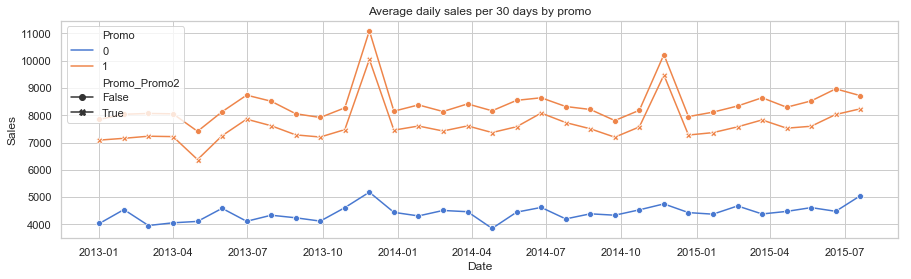

In [13]:
plt.figure(figsize=(15, 4))
data_train_ = data_train.copy()
data_train_ = data_train_[['Sales', 'Date', 'Promo', 'Promo2']]
data_train_['Promo_Promo2'] = data_train_['Promo'] & data_train_['Promo2']
data_train_ = data_train_.groupby([pd.Grouper(key='Date', freq='30D'), 'Promo', 'Promo_Promo2']).mean().reset_index()
ax = sns.lineplot(x='Date', y='Sales', hue='Promo', style='Promo_Promo2', data=data_train_, markers=True, dashes=False)
ax.set_title('Average daily sales per 30 days by promo')
plt.show()

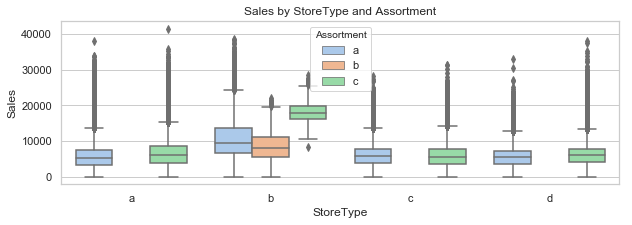

In [14]:
plt.figure(figsize=(10, 3))
ax = sns.boxplot(x='StoreType', y='Sales', hue='Assortment', palette='pastel', data=data_train)
ax.set_title('Sales by StoreType and Assortment')
plt.show()

## 数据预处理

In [1]:
from utils import preprocessing, cv, model
from sklearn.externals import joblib
import pandas as pd
import numpy as np

pd.set_option('display.max_columns', None)  
pd.set_option('display.expand_frame_repr', False)
pd.set_option('max_colwidth', -1)

data_train, data_test, data_store = preprocessing.read_csv(['data/train.csv', 'data/test.csv', 'data/store.csv'])
data_train = preprocessing.combine(data_train, data_store)
data_test = preprocessing.combine(data_test, data_store)
(X_train, y_train), X_test = preprocessing.transform(data_train, data_test)

In [2]:
X_train

,Store,DayOfWeek,Year,Month,Day,DayOfYear,WeekOfYear,Quarter,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,CompetitionOpen,Promo2,Promo2SinceWeek,Promo2SinceYear,Promo2Open,InPromoMonth,MeanLogSalesByStore,MeanLogSalesByDOW,MeanLogSalesByMonth
0,1,4,2015,7,31,212,31,3,1,1,0,1,3,1,1270.0,9.0,2008.0,84.0,0.0,NaN,NaN,0.00,0,8.468023,2.246065,8.847155
1,2,4,2015,7,31,212,31,3,1,1,0,1,1,1,570.0,11.0,2007.0,96.0,1.0,13.0,2010.0,64.50,1,8.508132,2.246065,8.847155
2,3,4,2015,7,31,212,31,3,1,1,0,1,1,1,14130.0,12.0,2006.0,108.0,1.0,14.0,2011.0,52.25,1,8.845571,2.246065,8.847155
3,4,4,2015,7,31,212,31,3,1,1,0,1,3,3,620.0,9.0,2009.0,72.0,0.0,NaN,NaN,0.00,0,9.173614,2.246065,8.847155
4,5,4,2015,7,31,212,31,3,1,1,0,1,1,1,29910.0,4.0,2015.0,3.0,0.0,NaN,NaN,0.00,0,8.450471,2.246065,8.847155
5,6,4,2015,7,31,212,31,3,1,1,0,1,1,1,310.0,12.0,2013.0,24.0,0.0,NaN,NaN,0.00,0,8.614492,2.246065,8.847155
6,7,4,2015,7,31,212,31,3,1,1,0,1,1,3,24000.0,4.0,2013.0,27.0,0.0,NaN,NaN,0.00,0,9.084556,2.246065,8.847155
7,8,4,2015,7,31,212,31,3,1,1,0,1,1,1,7520.0,10.0,2014.0,12.0,0.0,NaN,NaN,0.00,0,8.619814,2.246065,8.847155
8,9,4,2015,7,31,212,31,3,1,1,0,1,1,3,2030.0,8.0,2000.0,180.0,0.0,NaN,NaN,0.00,0,8.789255,2.246065,8.847155
9,10,4,2015,7,31,212,31,3,1,1,0,1,1,1,3160.0,9.0,2009.0,72.0,0.0,NaN,NaN,0.00,0,8.625046,2.246065,8.847155


## 执行过程

In [5]:
params = {
    'eta': 0.03,
    'max_depth': 10,
    'subsample': 0.8,
    'colsample_bytree': 0.7,
    'lambda': 0.2,
    'silent': 1,
    'seed': 12
}

m = model.Model(params, num_boost_round=5000, early_stopping_rounds=50)
m.train(X_train, y_train)

[0]	eval-rmse:8.02995	train-rmse:8.02033	eval-rmspe:0.914641	train-rmspe:0.914478
Multiple eval metrics have been passed: 'train-rmspe' will be used for early stopping.

Will train until train-rmspe hasn't improved in 50 rounds.
[1]	eval-rmse:7.78936	train-rmse:7.78018	eval-rmspe:0.887143	train-rmspe:0.887002
[2]	eval-rmse:7.55638	train-rmse:7.54694	eval-rmspe:0.860585	train-rmspe:0.860381
[3]	eval-rmse:7.33032	train-rmse:7.32096	eval-rmspe:0.834763	train-rmspe:0.834536
[4]	eval-rmse:7.11136	train-rmse:7.10172	eval-rmspe:0.809763	train-rmspe:0.809471
[5]	eval-rmse:6.89855	train-rmse:6.88907	eval-rmspe:0.785462	train-rmspe:0.785158
[6]	eval-rmse:6.69229	train-rmse:6.68287	eval-rmspe:0.761892	train-rmspe:0.761571
[7]	eval-rmse:6.49178	train-rmse:6.48264	eval-rmspe:0.739021	train-rmspe:0.738709
[8]	eval-rmse:6.29798	train-rmse:6.28863	eval-rmspe:0.716881	train-rmspe:0.716516
[9]	eval-rmse:6.10977	train-rmse:6.10014	eval-rmspe:0.695437	train-rmspe:0.695014
[10]	eval-rmse:5.92693	train-rmse

[97]	eval-rmse:0.451366	train-rmse:0.441732	eval-rmspe:0.050732	train-rmspe:0.049749
[98]	eval-rmse:0.439368	train-rmse:0.429644	eval-rmspe:0.049377	train-rmspe:0.048384
[99]	eval-rmse:0.428057	train-rmse:0.418103	eval-rmspe:0.048091	train-rmspe:0.047073
[100]	eval-rmse:0.4169	train-rmse:0.406837	eval-rmspe:0.046831	train-rmspe:0.045801
[101]	eval-rmse:0.405939	train-rmse:0.395906	eval-rmspe:0.045593	train-rmspe:0.044567
[102]	eval-rmse:0.39536	train-rmse:0.385455	eval-rmspe:0.044393	train-rmspe:0.043382
[103]	eval-rmse:0.385554	train-rmse:0.375365	eval-rmspe:0.04328	train-rmspe:0.042238
[104]	eval-rmse:0.375858	train-rmse:0.365591	eval-rmspe:0.042179	train-rmspe:0.041131
[105]	eval-rmse:0.366437	train-rmse:0.356002	eval-rmspe:0.041119	train-rmspe:0.040051
[106]	eval-rmse:0.357293	train-rmse:0.346789	eval-rmspe:0.040087	train-rmspe:0.039013
[107]	eval-rmse:0.348469	train-rmse:0.337872	eval-rmspe:0.039094	train-rmspe:0.03801
[108]	eval-rmse:0.339845	train-rmse:0.329308	eval-rmspe:0.0381

[193]	eval-rmse:0.138624	train-rmse:0.119908	eval-rmspe:0.01596	train-rmspe:0.01403
[194]	eval-rmse:0.138453	train-rmse:0.119697	eval-rmspe:0.015944	train-rmspe:0.01401
[195]	eval-rmse:0.138192	train-rmse:0.119405	eval-rmspe:0.015916	train-rmspe:0.013979
[196]	eval-rmse:0.138009	train-rmse:0.119134	eval-rmspe:0.015898	train-rmspe:0.013951
[197]	eval-rmse:0.1378	train-rmse:0.118942	eval-rmspe:0.015877	train-rmspe:0.013932
[198]	eval-rmse:0.137599	train-rmse:0.118707	eval-rmspe:0.015856	train-rmspe:0.013908
[199]	eval-rmse:0.137529	train-rmse:0.118549	eval-rmspe:0.015851	train-rmspe:0.013893
[200]	eval-rmse:0.137339	train-rmse:0.11835	eval-rmspe:0.015832	train-rmspe:0.013873
[201]	eval-rmse:0.13718	train-rmse:0.118168	eval-rmspe:0.015817	train-rmspe:0.013855
[202]	eval-rmse:0.137137	train-rmse:0.117988	eval-rmspe:0.015815	train-rmspe:0.013837
[203]	eval-rmse:0.136995	train-rmse:0.117794	eval-rmspe:0.015801	train-rmspe:0.013817
[204]	eval-rmse:0.136785	train-rmse:0.117584	eval-rmspe:0.015

[289]	eval-rmse:0.129739	train-rmse:0.108595	eval-rmspe:0.015029	train-rmspe:0.012812
[290]	eval-rmse:0.129733	train-rmse:0.108544	eval-rmspe:0.015028	train-rmspe:0.012806
[291]	eval-rmse:0.129633	train-rmse:0.108454	eval-rmspe:0.015017	train-rmspe:0.012796
[292]	eval-rmse:0.129608	train-rmse:0.108371	eval-rmspe:0.015014	train-rmspe:0.012786
[293]	eval-rmse:0.129533	train-rmse:0.108287	eval-rmspe:0.015005	train-rmspe:0.012776
[294]	eval-rmse:0.129492	train-rmse:0.10822	eval-rmspe:0.015	train-rmspe:0.012768
[295]	eval-rmse:0.129471	train-rmse:0.108128	eval-rmspe:0.014998	train-rmspe:0.012757
[296]	eval-rmse:0.129428	train-rmse:0.10806	eval-rmspe:0.014993	train-rmspe:0.012749
[297]	eval-rmse:0.1294	train-rmse:0.108029	eval-rmspe:0.01499	train-rmspe:0.012746
[298]	eval-rmse:0.129306	train-rmse:0.107921	eval-rmspe:0.014979	train-rmspe:0.012733
[299]	eval-rmse:0.129271	train-rmse:0.107869	eval-rmspe:0.014975	train-rmspe:0.012727
[300]	eval-rmse:0.129215	train-rmse:0.107809	eval-rmspe:0.0149

[385]	eval-rmse:0.125727	train-rmse:0.102837	eval-rmspe:0.014559	train-rmspe:0.012137
[386]	eval-rmse:0.125786	train-rmse:0.102799	eval-rmspe:0.014566	train-rmspe:0.012133
[387]	eval-rmse:0.125729	train-rmse:0.102733	eval-rmspe:0.01456	train-rmspe:0.012125
[388]	eval-rmse:0.125708	train-rmse:0.102713	eval-rmspe:0.014557	train-rmspe:0.012123
[389]	eval-rmse:0.125695	train-rmse:0.102681	eval-rmspe:0.014556	train-rmspe:0.012119
[390]	eval-rmse:0.125663	train-rmse:0.102634	eval-rmspe:0.014552	train-rmspe:0.012114
[391]	eval-rmse:0.125655	train-rmse:0.102616	eval-rmspe:0.014551	train-rmspe:0.012112
[392]	eval-rmse:0.12562	train-rmse:0.102574	eval-rmspe:0.014547	train-rmspe:0.012107
[393]	eval-rmse:0.125576	train-rmse:0.102526	eval-rmspe:0.014542	train-rmspe:0.012102
[394]	eval-rmse:0.125571	train-rmse:0.102507	eval-rmspe:0.014542	train-rmspe:0.012099
[395]	eval-rmse:0.125531	train-rmse:0.102435	eval-rmspe:0.014537	train-rmspe:0.01209
[396]	eval-rmse:0.125503	train-rmse:0.102405	eval-rmspe:0

[481]	eval-rmse:0.123475	train-rmse:0.099014	eval-rmspe:0.014289	train-rmspe:0.011687
[482]	eval-rmse:0.123461	train-rmse:0.098992	eval-rmspe:0.014287	train-rmspe:0.011685
[483]	eval-rmse:0.123454	train-rmse:0.098972	eval-rmspe:0.014287	train-rmspe:0.011682
[484]	eval-rmse:0.123442	train-rmse:0.098948	eval-rmspe:0.014285	train-rmspe:0.01168
[485]	eval-rmse:0.123438	train-rmse:0.09893	eval-rmspe:0.014284	train-rmspe:0.011678
[486]	eval-rmse:0.123407	train-rmse:0.098878	eval-rmspe:0.01428	train-rmspe:0.011671
[487]	eval-rmse:0.123381	train-rmse:0.098834	eval-rmspe:0.014277	train-rmspe:0.011666
[488]	eval-rmse:0.123361	train-rmse:0.098809	eval-rmspe:0.014275	train-rmspe:0.011663
[489]	eval-rmse:0.123361	train-rmse:0.098797	eval-rmspe:0.014275	train-rmspe:0.011662
[490]	eval-rmse:0.123334	train-rmse:0.098747	eval-rmspe:0.014271	train-rmspe:0.011656
[491]	eval-rmse:0.123326	train-rmse:0.098708	eval-rmspe:0.014271	train-rmspe:0.011651
[492]	eval-rmse:0.123305	train-rmse:0.098675	eval-rmspe:0

[577]	eval-rmse:0.121591	train-rmse:0.095153	eval-rmspe:0.014061	train-rmspe:0.011232
[578]	eval-rmse:0.121575	train-rmse:0.095135	eval-rmspe:0.014059	train-rmspe:0.01123
[579]	eval-rmse:0.12156	train-rmse:0.095119	eval-rmspe:0.014057	train-rmspe:0.011228
[580]	eval-rmse:0.12153	train-rmse:0.095081	eval-rmspe:0.014054	train-rmspe:0.011224
[581]	eval-rmse:0.121517	train-rmse:0.095062	eval-rmspe:0.014052	train-rmspe:0.011221
[582]	eval-rmse:0.121506	train-rmse:0.095046	eval-rmspe:0.014051	train-rmspe:0.011219
[583]	eval-rmse:0.121482	train-rmse:0.095007	eval-rmspe:0.014048	train-rmspe:0.011215
[584]	eval-rmse:0.121469	train-rmse:0.094979	eval-rmspe:0.014046	train-rmspe:0.011212
[585]	eval-rmse:0.121469	train-rmse:0.094974	eval-rmspe:0.014046	train-rmspe:0.011211
[586]	eval-rmse:0.121442	train-rmse:0.094927	eval-rmspe:0.014043	train-rmspe:0.011206
[587]	eval-rmse:0.121425	train-rmse:0.094893	eval-rmspe:0.014041	train-rmspe:0.011202
[588]	eval-rmse:0.121387	train-rmse:0.094835	eval-rmspe:0

[673]	eval-rmse:0.120279	train-rmse:0.092353	eval-rmspe:0.013904	train-rmspe:0.010903
[674]	eval-rmse:0.120262	train-rmse:0.092317	eval-rmspe:0.013902	train-rmspe:0.010899
[675]	eval-rmse:0.120246	train-rmse:0.092282	eval-rmspe:0.0139	train-rmspe:0.010895
[676]	eval-rmse:0.120217	train-rmse:0.092239	eval-rmspe:0.013897	train-rmspe:0.01089
[677]	eval-rmse:0.120179	train-rmse:0.092202	eval-rmspe:0.013892	train-rmspe:0.010886
[678]	eval-rmse:0.120179	train-rmse:0.092176	eval-rmspe:0.013892	train-rmspe:0.010882
[679]	eval-rmse:0.120164	train-rmse:0.092149	eval-rmspe:0.01389	train-rmspe:0.010879
[680]	eval-rmse:0.120156	train-rmse:0.092127	eval-rmspe:0.013889	train-rmspe:0.010877
[681]	eval-rmse:0.120152	train-rmse:0.092118	eval-rmspe:0.013889	train-rmspe:0.010876
[682]	eval-rmse:0.120133	train-rmse:0.092086	eval-rmspe:0.013887	train-rmspe:0.010872
[683]	eval-rmse:0.120125	train-rmse:0.092066	eval-rmspe:0.013886	train-rmspe:0.01087
[684]	eval-rmse:0.120108	train-rmse:0.092037	eval-rmspe:0.0

[769]	eval-rmse:0.119087	train-rmse:0.089533	eval-rmspe:0.013761	train-rmspe:0.010571
[770]	eval-rmse:0.119066	train-rmse:0.089504	eval-rmspe:0.013759	train-rmspe:0.010567
[771]	eval-rmse:0.119055	train-rmse:0.089479	eval-rmspe:0.013758	train-rmspe:0.010564
[772]	eval-rmse:0.11903	train-rmse:0.089452	eval-rmspe:0.013755	train-rmspe:0.010561
[773]	eval-rmse:0.11899	train-rmse:0.089395	eval-rmspe:0.01375	train-rmspe:0.010554
[774]	eval-rmse:0.118976	train-rmse:0.089347	eval-rmspe:0.013748	train-rmspe:0.010548
[775]	eval-rmse:0.11896	train-rmse:0.089314	eval-rmspe:0.013746	train-rmspe:0.010544
[776]	eval-rmse:0.118959	train-rmse:0.08928	eval-rmspe:0.013746	train-rmspe:0.010539
[777]	eval-rmse:0.118957	train-rmse:0.089261	eval-rmspe:0.013746	train-rmspe:0.010537
[778]	eval-rmse:0.118951	train-rmse:0.089252	eval-rmspe:0.013745	train-rmspe:0.010536
[779]	eval-rmse:0.118986	train-rmse:0.089237	eval-rmspe:0.013749	train-rmspe:0.010534
[780]	eval-rmse:0.118976	train-rmse:0.089218	eval-rmspe:0.0

[865]	eval-rmse:0.11826	train-rmse:0.087189	eval-rmspe:0.013659	train-rmspe:0.010287
[866]	eval-rmse:0.118252	train-rmse:0.087166	eval-rmspe:0.013659	train-rmspe:0.010284
[867]	eval-rmse:0.118289	train-rmse:0.087128	eval-rmspe:0.013663	train-rmspe:0.010279
[868]	eval-rmse:0.118298	train-rmse:0.087114	eval-rmspe:0.013663	train-rmspe:0.010277
[869]	eval-rmse:0.118289	train-rmse:0.087094	eval-rmspe:0.013662	train-rmspe:0.010275
[870]	eval-rmse:0.118277	train-rmse:0.087063	eval-rmspe:0.013661	train-rmspe:0.010271
[871]	eval-rmse:0.118306	train-rmse:0.087043	eval-rmspe:0.013664	train-rmspe:0.010266
[872]	eval-rmse:0.118302	train-rmse:0.087021	eval-rmspe:0.013664	train-rmspe:0.010264
[873]	eval-rmse:0.118302	train-rmse:0.086999	eval-rmspe:0.013664	train-rmspe:0.010261
[874]	eval-rmse:0.118353	train-rmse:0.086967	eval-rmspe:0.01367	train-rmspe:0.010257
[875]	eval-rmse:0.118351	train-rmse:0.086946	eval-rmspe:0.013669	train-rmspe:0.010255
[876]	eval-rmse:0.118328	train-rmse:0.086913	eval-rmspe:

[961]	eval-rmse:0.117702	train-rmse:0.085043	eval-rmspe:0.01359	train-rmspe:0.010029
[962]	eval-rmse:0.117699	train-rmse:0.085024	eval-rmspe:0.013589	train-rmspe:0.010026
[963]	eval-rmse:0.117693	train-rmse:0.085004	eval-rmspe:0.013589	train-rmspe:0.010024
[964]	eval-rmse:0.117687	train-rmse:0.084987	eval-rmspe:0.013588	train-rmspe:0.010022
[965]	eval-rmse:0.117684	train-rmse:0.084968	eval-rmspe:0.013587	train-rmspe:0.01002
[966]	eval-rmse:0.117682	train-rmse:0.084958	eval-rmspe:0.013587	train-rmspe:0.010018
[967]	eval-rmse:0.117677	train-rmse:0.084947	eval-rmspe:0.013587	train-rmspe:0.010017
[968]	eval-rmse:0.117669	train-rmse:0.084935	eval-rmspe:0.013586	train-rmspe:0.010016
[969]	eval-rmse:0.117672	train-rmse:0.08492	eval-rmspe:0.013586	train-rmspe:0.010014
[970]	eval-rmse:0.117665	train-rmse:0.084906	eval-rmspe:0.013585	train-rmspe:0.010012
[971]	eval-rmse:0.117688	train-rmse:0.084886	eval-rmspe:0.013588	train-rmspe:0.01001
[972]	eval-rmse:0.117686	train-rmse:0.084855	eval-rmspe:0.

[1057]	eval-rmse:0.117013	train-rmse:0.083172	eval-rmspe:0.013506	train-rmspe:0.009806
[1058]	eval-rmse:0.117018	train-rmse:0.083154	eval-rmspe:0.013506	train-rmspe:0.009804
[1059]	eval-rmse:0.117015	train-rmse:0.083136	eval-rmspe:0.013506	train-rmspe:0.009802
[1060]	eval-rmse:0.11701	train-rmse:0.083115	eval-rmspe:0.013505	train-rmspe:0.0098
[1061]	eval-rmse:0.116999	train-rmse:0.083095	eval-rmspe:0.013504	train-rmspe:0.009797
[1062]	eval-rmse:0.116997	train-rmse:0.083088	eval-rmspe:0.013504	train-rmspe:0.009797
[1063]	eval-rmse:0.116998	train-rmse:0.083076	eval-rmspe:0.013504	train-rmspe:0.009795
[1064]	eval-rmse:0.116979	train-rmse:0.083049	eval-rmspe:0.013501	train-rmspe:0.009792
[1065]	eval-rmse:0.116979	train-rmse:0.08304	eval-rmspe:0.013501	train-rmspe:0.009791
[1066]	eval-rmse:0.116965	train-rmse:0.083012	eval-rmspe:0.0135	train-rmspe:0.009788
[1067]	eval-rmse:0.116948	train-rmse:0.082974	eval-rmspe:0.013498	train-rmspe:0.009783
[1068]	eval-rmse:0.116934	train-rmse:0.082942	eva

[1152]	eval-rmse:0.116423	train-rmse:0.08129	eval-rmspe:0.013436	train-rmspe:0.009574
[1153]	eval-rmse:0.116422	train-rmse:0.081277	eval-rmspe:0.013436	train-rmspe:0.009573
[1154]	eval-rmse:0.116402	train-rmse:0.081236	eval-rmspe:0.013434	train-rmspe:0.009568
[1155]	eval-rmse:0.116395	train-rmse:0.081216	eval-rmspe:0.013433	train-rmspe:0.009565
[1156]	eval-rmse:0.116394	train-rmse:0.081197	eval-rmspe:0.013433	train-rmspe:0.009563
[1157]	eval-rmse:0.116385	train-rmse:0.081185	eval-rmspe:0.013432	train-rmspe:0.009562
[1158]	eval-rmse:0.116377	train-rmse:0.08117	eval-rmspe:0.013431	train-rmspe:0.00956
[1159]	eval-rmse:0.116378	train-rmse:0.081162	eval-rmspe:0.013431	train-rmspe:0.009559
[1160]	eval-rmse:0.116374	train-rmse:0.081142	eval-rmspe:0.013431	train-rmspe:0.009557
[1161]	eval-rmse:0.11637	train-rmse:0.081123	eval-rmspe:0.01343	train-rmspe:0.009554
[1162]	eval-rmse:0.11635	train-rmse:0.081099	eval-rmspe:0.013428	train-rmspe:0.009552
[1163]	eval-rmse:0.116353	train-rmse:0.081086	eva

[1247]	eval-rmse:0.11595	train-rmse:0.079619	eval-rmspe:0.01338	train-rmspe:0.009368
[1248]	eval-rmse:0.115951	train-rmse:0.079591	eval-rmspe:0.01338	train-rmspe:0.009365
[1249]	eval-rmse:0.115942	train-rmse:0.079566	eval-rmspe:0.013379	train-rmspe:0.009362
[1250]	eval-rmse:0.115943	train-rmse:0.079554	eval-rmspe:0.013379	train-rmspe:0.009361
[1251]	eval-rmse:0.115929	train-rmse:0.079526	eval-rmspe:0.013377	train-rmspe:0.009357
[1252]	eval-rmse:0.11593	train-rmse:0.079517	eval-rmspe:0.013377	train-rmspe:0.009356
[1253]	eval-rmse:0.115929	train-rmse:0.079504	eval-rmspe:0.013377	train-rmspe:0.009354
[1254]	eval-rmse:0.115926	train-rmse:0.079486	eval-rmspe:0.013377	train-rmspe:0.009352
[1255]	eval-rmse:0.115932	train-rmse:0.079463	eval-rmspe:0.013377	train-rmspe:0.009349
[1256]	eval-rmse:0.115926	train-rmse:0.079446	eval-rmspe:0.013376	train-rmspe:0.009347
[1257]	eval-rmse:0.115926	train-rmse:0.079437	eval-rmspe:0.013376	train-rmspe:0.009346
[1258]	eval-rmse:0.115912	train-rmse:0.07941	ev

[1342]	eval-rmse:0.115518	train-rmse:0.078055	eval-rmspe:0.013328	train-rmspe:0.009181
[1343]	eval-rmse:0.115518	train-rmse:0.078037	eval-rmspe:0.013328	train-rmspe:0.009179
[1344]	eval-rmse:0.115513	train-rmse:0.078025	eval-rmspe:0.013327	train-rmspe:0.009177
[1345]	eval-rmse:0.115508	train-rmse:0.078013	eval-rmspe:0.013327	train-rmspe:0.009176
[1346]	eval-rmse:0.115506	train-rmse:0.077999	eval-rmspe:0.013327	train-rmspe:0.009174
[1347]	eval-rmse:0.115495	train-rmse:0.077983	eval-rmspe:0.013325	train-rmspe:0.009172
[1348]	eval-rmse:0.115495	train-rmse:0.077975	eval-rmspe:0.013325	train-rmspe:0.009172
[1349]	eval-rmse:0.115488	train-rmse:0.077954	eval-rmspe:0.013325	train-rmspe:0.009169
[1350]	eval-rmse:0.115477	train-rmse:0.07793	eval-rmspe:0.013323	train-rmspe:0.009166
[1351]	eval-rmse:0.115472	train-rmse:0.077913	eval-rmspe:0.013323	train-rmspe:0.009164
[1352]	eval-rmse:0.115473	train-rmse:0.077902	eval-rmspe:0.013323	train-rmspe:0.009163
[1353]	eval-rmse:0.115464	train-rmse:0.07788

[1437]	eval-rmse:0.115269	train-rmse:0.076731	eval-rmspe:0.013299	train-rmspe:0.009022
[1438]	eval-rmse:0.115267	train-rmse:0.076721	eval-rmspe:0.013298	train-rmspe:0.009021
[1439]	eval-rmse:0.115267	train-rmse:0.076713	eval-rmspe:0.013298	train-rmspe:0.00902
[1440]	eval-rmse:0.115264	train-rmse:0.076696	eval-rmspe:0.013298	train-rmspe:0.009018
[1441]	eval-rmse:0.115257	train-rmse:0.076678	eval-rmspe:0.013297	train-rmspe:0.009016
[1442]	eval-rmse:0.115256	train-rmse:0.076675	eval-rmspe:0.013297	train-rmspe:0.009015
[1443]	eval-rmse:0.115249	train-rmse:0.076656	eval-rmspe:0.013296	train-rmspe:0.009013
[1444]	eval-rmse:0.115238	train-rmse:0.076639	eval-rmspe:0.013295	train-rmspe:0.009011
[1445]	eval-rmse:0.115233	train-rmse:0.07662	eval-rmspe:0.013295	train-rmspe:0.009009
[1446]	eval-rmse:0.115231	train-rmse:0.076609	eval-rmspe:0.013294	train-rmspe:0.009008
[1447]	eval-rmse:0.115231	train-rmse:0.076606	eval-rmspe:0.013294	train-rmspe:0.009007
[1448]	eval-rmse:0.11521	train-rmse:0.076568	

[1532]	eval-rmse:0.115015	train-rmse:0.075464	eval-rmspe:0.013269	train-rmspe:0.008871
[1533]	eval-rmse:0.115014	train-rmse:0.075457	eval-rmspe:0.013269	train-rmspe:0.00887
[1534]	eval-rmse:0.115012	train-rmse:0.075444	eval-rmspe:0.013269	train-rmspe:0.008869
[1535]	eval-rmse:0.115011	train-rmse:0.075435	eval-rmspe:0.013269	train-rmspe:0.008868
[1536]	eval-rmse:0.115009	train-rmse:0.07542	eval-rmspe:0.013269	train-rmspe:0.008866
[1537]	eval-rmse:0.115	train-rmse:0.075401	eval-rmspe:0.013268	train-rmspe:0.008864
[1538]	eval-rmse:0.114998	train-rmse:0.075393	eval-rmspe:0.013267	train-rmspe:0.008863
[1539]	eval-rmse:0.115	train-rmse:0.07538	eval-rmspe:0.013268	train-rmspe:0.008861
[1540]	eval-rmse:0.114995	train-rmse:0.075363	eval-rmspe:0.013267	train-rmspe:0.008859
[1541]	eval-rmse:0.114989	train-rmse:0.075354	eval-rmspe:0.013266	train-rmspe:0.008858
[1542]	eval-rmse:0.114987	train-rmse:0.075345	eval-rmspe:0.013266	train-rmspe:0.008857
[1543]	eval-rmse:0.114988	train-rmse:0.07533	eval-rm

[1627]	eval-rmse:0.114762	train-rmse:0.0743	eval-rmspe:0.01324	train-rmspe:0.008731
[1628]	eval-rmse:0.114754	train-rmse:0.074284	eval-rmspe:0.013239	train-rmspe:0.008729
[1629]	eval-rmse:0.114753	train-rmse:0.074272	eval-rmspe:0.013239	train-rmspe:0.008727
[1630]	eval-rmse:0.114752	train-rmse:0.074264	eval-rmspe:0.013239	train-rmspe:0.008726
[1631]	eval-rmse:0.114746	train-rmse:0.074249	eval-rmspe:0.013238	train-rmspe:0.008725
[1632]	eval-rmse:0.114739	train-rmse:0.07424	eval-rmspe:0.013237	train-rmspe:0.008724
[1633]	eval-rmse:0.114734	train-rmse:0.074228	eval-rmspe:0.013237	train-rmspe:0.008722
[1634]	eval-rmse:0.114735	train-rmse:0.074211	eval-rmspe:0.013237	train-rmspe:0.00872
[1635]	eval-rmse:0.114738	train-rmse:0.0742	eval-rmspe:0.013237	train-rmspe:0.008719
[1636]	eval-rmse:0.114736	train-rmse:0.074188	eval-rmspe:0.013237	train-rmspe:0.008718
[1637]	eval-rmse:0.114754	train-rmse:0.074177	eval-rmspe:0.013239	train-rmspe:0.008716
[1638]	eval-rmse:0.114757	train-rmse:0.07416	eval-

[1722]	eval-rmse:0.114584	train-rmse:0.073173	eval-rmspe:0.013219	train-rmspe:0.008596
[1723]	eval-rmse:0.11458	train-rmse:0.073163	eval-rmspe:0.013219	train-rmspe:0.008595
[1724]	eval-rmse:0.114578	train-rmse:0.073155	eval-rmspe:0.013219	train-rmspe:0.008594
[1725]	eval-rmse:0.114574	train-rmse:0.07314	eval-rmspe:0.013218	train-rmspe:0.008592
[1726]	eval-rmse:0.114572	train-rmse:0.073133	eval-rmspe:0.013218	train-rmspe:0.008591
[1727]	eval-rmse:0.11457	train-rmse:0.073125	eval-rmspe:0.013218	train-rmspe:0.00859
[1728]	eval-rmse:0.114569	train-rmse:0.073117	eval-rmspe:0.013218	train-rmspe:0.008589
[1729]	eval-rmse:0.114567	train-rmse:0.073104	eval-rmspe:0.013217	train-rmspe:0.008588
[1730]	eval-rmse:0.114567	train-rmse:0.073084	eval-rmspe:0.013217	train-rmspe:0.008585
[1731]	eval-rmse:0.114562	train-rmse:0.07307	eval-rmspe:0.013217	train-rmspe:0.008583
[1732]	eval-rmse:0.11456	train-rmse:0.073056	eval-rmspe:0.013217	train-rmspe:0.008582
[1733]	eval-rmse:0.114563	train-rmse:0.073045	eva

[1817]	eval-rmse:0.114462	train-rmse:0.072091	eval-rmspe:0.013205	train-rmspe:0.008466
[1818]	eval-rmse:0.114462	train-rmse:0.07208	eval-rmspe:0.013205	train-rmspe:0.008464
[1819]	eval-rmse:0.11447	train-rmse:0.072077	eval-rmspe:0.013206	train-rmspe:0.008464
[1820]	eval-rmse:0.11447	train-rmse:0.07207	eval-rmspe:0.013206	train-rmspe:0.008463
[1821]	eval-rmse:0.114469	train-rmse:0.07206	eval-rmspe:0.013205	train-rmspe:0.008462
[1822]	eval-rmse:0.114464	train-rmse:0.07205	eval-rmspe:0.013205	train-rmspe:0.008461
[1823]	eval-rmse:0.114462	train-rmse:0.072043	eval-rmspe:0.013205	train-rmspe:0.00846
[1824]	eval-rmse:0.114458	train-rmse:0.072025	eval-rmspe:0.013204	train-rmspe:0.008458
[1825]	eval-rmse:0.114457	train-rmse:0.072013	eval-rmspe:0.013204	train-rmspe:0.008456
[1826]	eval-rmse:0.114464	train-rmse:0.072002	eval-rmspe:0.013205	train-rmspe:0.008455
[1827]	eval-rmse:0.114466	train-rmse:0.071995	eval-rmspe:0.013205	train-rmspe:0.008454
[1828]	eval-rmse:0.114465	train-rmse:0.071987	eval

[1912]	eval-rmse:0.11436	train-rmse:0.071086	eval-rmspe:0.013193	train-rmspe:0.008345
[1913]	eval-rmse:0.114359	train-rmse:0.071076	eval-rmspe:0.013193	train-rmspe:0.008344
[1914]	eval-rmse:0.114363	train-rmse:0.071064	eval-rmspe:0.013193	train-rmspe:0.008342
[1915]	eval-rmse:0.114362	train-rmse:0.071058	eval-rmspe:0.013193	train-rmspe:0.008342
[1916]	eval-rmse:0.114362	train-rmse:0.071047	eval-rmspe:0.013193	train-rmspe:0.00834
[1917]	eval-rmse:0.114358	train-rmse:0.071038	eval-rmspe:0.013192	train-rmspe:0.008339
[1918]	eval-rmse:0.114353	train-rmse:0.071024	eval-rmspe:0.013192	train-rmspe:0.008337
[1919]	eval-rmse:0.11435	train-rmse:0.071016	eval-rmspe:0.013191	train-rmspe:0.008336
[1920]	eval-rmse:0.114353	train-rmse:0.071006	eval-rmspe:0.013192	train-rmspe:0.008334
[1921]	eval-rmse:0.11435	train-rmse:0.070997	eval-rmspe:0.013191	train-rmspe:0.008333
[1922]	eval-rmse:0.114355	train-rmse:0.070993	eval-rmspe:0.013192	train-rmspe:0.008333
[1923]	eval-rmse:0.114353	train-rmse:0.070985	e

[2007]	eval-rmse:0.114275	train-rmse:0.070179	eval-rmspe:0.013182	train-rmspe:0.008233
[2008]	eval-rmse:0.114278	train-rmse:0.070174	eval-rmspe:0.013182	train-rmspe:0.008232
[2009]	eval-rmse:0.114276	train-rmse:0.07016	eval-rmspe:0.013182	train-rmspe:0.008231
[2010]	eval-rmse:0.114276	train-rmse:0.070152	eval-rmspe:0.013182	train-rmspe:0.00823
[2011]	eval-rmse:0.114273	train-rmse:0.070146	eval-rmspe:0.013182	train-rmspe:0.008229
[2012]	eval-rmse:0.114267	train-rmse:0.070132	eval-rmspe:0.013181	train-rmspe:0.008227
[2013]	eval-rmse:0.114267	train-rmse:0.070116	eval-rmspe:0.013181	train-rmspe:0.008225
[2014]	eval-rmse:0.114265	train-rmse:0.070106	eval-rmspe:0.013181	train-rmspe:0.008224
[2015]	eval-rmse:0.114265	train-rmse:0.070095	eval-rmspe:0.013181	train-rmspe:0.008223
[2016]	eval-rmse:0.11426	train-rmse:0.070081	eval-rmspe:0.01318	train-rmspe:0.008221
[2017]	eval-rmse:0.11426	train-rmse:0.070072	eval-rmspe:0.013181	train-rmspe:0.00822
[2018]	eval-rmse:0.11426	train-rmse:0.070066	eval

[2102]	eval-rmse:0.114189	train-rmse:0.069293	eval-rmspe:0.013172	train-rmspe:0.008127
[2103]	eval-rmse:0.114192	train-rmse:0.069278	eval-rmspe:0.013172	train-rmspe:0.008125
[2104]	eval-rmse:0.114197	train-rmse:0.069272	eval-rmspe:0.013173	train-rmspe:0.008124
[2105]	eval-rmse:0.1142	train-rmse:0.069267	eval-rmspe:0.013173	train-rmspe:0.008124
[2106]	eval-rmse:0.1142	train-rmse:0.069262	eval-rmspe:0.013173	train-rmspe:0.008123
[2107]	eval-rmse:0.114199	train-rmse:0.06925	eval-rmspe:0.013173	train-rmspe:0.008121
[2108]	eval-rmse:0.114196	train-rmse:0.069243	eval-rmspe:0.013173	train-rmspe:0.008121
[2109]	eval-rmse:0.114191	train-rmse:0.069233	eval-rmspe:0.013172	train-rmspe:0.008119
[2110]	eval-rmse:0.114187	train-rmse:0.069223	eval-rmspe:0.013172	train-rmspe:0.008118
[2111]	eval-rmse:0.114187	train-rmse:0.069217	eval-rmspe:0.013172	train-rmspe:0.008117
[2112]	eval-rmse:0.114179	train-rmse:0.069204	eval-rmspe:0.013171	train-rmspe:0.008116
[2113]	eval-rmse:0.11418	train-rmse:0.069192	eva

[2197]	eval-rmse:0.11409	train-rmse:0.068478	eval-rmspe:0.013161	train-rmspe:0.008028
[2198]	eval-rmse:0.114089	train-rmse:0.068472	eval-rmspe:0.013161	train-rmspe:0.008027
[2199]	eval-rmse:0.114086	train-rmse:0.068465	eval-rmspe:0.01316	train-rmspe:0.008027
[2200]	eval-rmse:0.114079	train-rmse:0.068459	eval-rmspe:0.013159	train-rmspe:0.008026
[2201]	eval-rmse:0.114078	train-rmse:0.06845	eval-rmspe:0.013159	train-rmspe:0.008025
[2202]	eval-rmse:0.114076	train-rmse:0.068437	eval-rmspe:0.013159	train-rmspe:0.008023
[2203]	eval-rmse:0.114073	train-rmse:0.068426	eval-rmspe:0.013159	train-rmspe:0.008022
[2204]	eval-rmse:0.114077	train-rmse:0.068417	eval-rmspe:0.013159	train-rmspe:0.008021
[2205]	eval-rmse:0.114076	train-rmse:0.068408	eval-rmspe:0.013159	train-rmspe:0.00802
[2206]	eval-rmse:0.114077	train-rmse:0.068403	eval-rmspe:0.013159	train-rmspe:0.008019
[2207]	eval-rmse:0.114077	train-rmse:0.068393	eval-rmspe:0.013159	train-rmspe:0.008018
[2208]	eval-rmse:0.114075	train-rmse:0.068386	e

[2292]	eval-rmse:0.114093	train-rmse:0.067688	eval-rmspe:0.013161	train-rmspe:0.007933
[2293]	eval-rmse:0.114092	train-rmse:0.067683	eval-rmspe:0.013161	train-rmspe:0.007932
[2294]	eval-rmse:0.114096	train-rmse:0.067679	eval-rmspe:0.013161	train-rmspe:0.007932
[2295]	eval-rmse:0.114094	train-rmse:0.067665	eval-rmspe:0.013161	train-rmspe:0.00793
[2296]	eval-rmse:0.114092	train-rmse:0.067657	eval-rmspe:0.013161	train-rmspe:0.007929
[2297]	eval-rmse:0.11409	train-rmse:0.067651	eval-rmspe:0.013161	train-rmspe:0.007928
[2298]	eval-rmse:0.114085	train-rmse:0.067639	eval-rmspe:0.01316	train-rmspe:0.007927
[2299]	eval-rmse:0.114085	train-rmse:0.067629	eval-rmspe:0.01316	train-rmspe:0.007926
[2300]	eval-rmse:0.114086	train-rmse:0.067622	eval-rmspe:0.01316	train-rmspe:0.007925
[2301]	eval-rmse:0.114083	train-rmse:0.067613	eval-rmspe:0.01316	train-rmspe:0.007924
[2302]	eval-rmse:0.114082	train-rmse:0.067598	eval-rmspe:0.01316	train-rmspe:0.007922
[2303]	eval-rmse:0.114084	train-rmse:0.067592	eval

[2387]	eval-rmse:0.114046	train-rmse:0.066881	eval-rmspe:0.013156	train-rmspe:0.007834
[2388]	eval-rmse:0.114051	train-rmse:0.066874	eval-rmspe:0.013156	train-rmspe:0.007833
[2389]	eval-rmse:0.114047	train-rmse:0.066863	eval-rmspe:0.013156	train-rmspe:0.007832
[2390]	eval-rmse:0.114048	train-rmse:0.066853	eval-rmspe:0.013156	train-rmspe:0.007831
[2391]	eval-rmse:0.114049	train-rmse:0.066847	eval-rmspe:0.013156	train-rmspe:0.00783
[2392]	eval-rmse:0.114051	train-rmse:0.066839	eval-rmspe:0.013156	train-rmspe:0.007829
[2393]	eval-rmse:0.114052	train-rmse:0.066829	eval-rmspe:0.013156	train-rmspe:0.007828
[2394]	eval-rmse:0.114058	train-rmse:0.06682	eval-rmspe:0.013157	train-rmspe:0.007827
[2395]	eval-rmse:0.114056	train-rmse:0.066811	eval-rmspe:0.013157	train-rmspe:0.007826
[2396]	eval-rmse:0.114057	train-rmse:0.066803	eval-rmspe:0.013157	train-rmspe:0.007825
[2397]	eval-rmse:0.114054	train-rmse:0.066792	eval-rmspe:0.013157	train-rmspe:0.007824
[2398]	eval-rmse:0.114055	train-rmse:0.066782

[2482]	eval-rmse:0.113999	train-rmse:0.066094	eval-rmspe:0.01315	train-rmspe:0.00774
[2483]	eval-rmse:0.114003	train-rmse:0.066088	eval-rmspe:0.013151	train-rmspe:0.007739
[2484]	eval-rmse:0.114004	train-rmse:0.066082	eval-rmspe:0.013151	train-rmspe:0.007739
[2485]	eval-rmse:0.114001	train-rmse:0.066074	eval-rmspe:0.013151	train-rmspe:0.007738
[2486]	eval-rmse:0.114	train-rmse:0.066067	eval-rmspe:0.01315	train-rmspe:0.007737
[2487]	eval-rmse:0.113997	train-rmse:0.066058	eval-rmspe:0.01315	train-rmspe:0.007736
[2488]	eval-rmse:0.114	train-rmse:0.066051	eval-rmspe:0.01315	train-rmspe:0.007735
[2489]	eval-rmse:0.114	train-rmse:0.066044	eval-rmspe:0.01315	train-rmspe:0.007734
[2490]	eval-rmse:0.113998	train-rmse:0.066039	eval-rmspe:0.01315	train-rmspe:0.007734
[2491]	eval-rmse:0.113995	train-rmse:0.066031	eval-rmspe:0.01315	train-rmspe:0.007733
[2492]	eval-rmse:0.114005	train-rmse:0.066025	eval-rmspe:0.013151	train-rmspe:0.007732
[2493]	eval-rmse:0.114004	train-rmse:0.066018	eval-rmspe:0.0

[2577]	eval-rmse:0.114001	train-rmse:0.065373	eval-rmspe:0.01315	train-rmspe:0.007654
[2578]	eval-rmse:0.114	train-rmse:0.065363	eval-rmspe:0.01315	train-rmspe:0.007652
[2579]	eval-rmse:0.113998	train-rmse:0.065355	eval-rmspe:0.01315	train-rmspe:0.007652
[2580]	eval-rmse:0.113998	train-rmse:0.065349	eval-rmspe:0.01315	train-rmspe:0.007651
[2581]	eval-rmse:0.113996	train-rmse:0.06534	eval-rmspe:0.01315	train-rmspe:0.00765
[2582]	eval-rmse:0.113993	train-rmse:0.065332	eval-rmspe:0.013149	train-rmspe:0.007649
[2583]	eval-rmse:0.11399	train-rmse:0.065326	eval-rmspe:0.013149	train-rmspe:0.007648
[2584]	eval-rmse:0.113991	train-rmse:0.065319	eval-rmspe:0.013149	train-rmspe:0.007647
[2585]	eval-rmse:0.11399	train-rmse:0.06531	eval-rmspe:0.013149	train-rmspe:0.007646
[2586]	eval-rmse:0.11399	train-rmse:0.065301	eval-rmspe:0.013149	train-rmspe:0.007645
[2587]	eval-rmse:0.11399	train-rmse:0.065291	eval-rmspe:0.013149	train-rmspe:0.007644
[2588]	eval-rmse:0.113989	train-rmse:0.065284	eval-rmspe:0

[2672]	eval-rmse:0.113979	train-rmse:0.064635	eval-rmspe:0.013148	train-rmspe:0.007565
[2673]	eval-rmse:0.113977	train-rmse:0.064629	eval-rmspe:0.013147	train-rmspe:0.007564
[2674]	eval-rmse:0.113973	train-rmse:0.06462	eval-rmspe:0.013147	train-rmspe:0.007563
[2675]	eval-rmse:0.113972	train-rmse:0.064613	eval-rmspe:0.013147	train-rmspe:0.007562
[2676]	eval-rmse:0.113966	train-rmse:0.064605	eval-rmspe:0.013146	train-rmspe:0.007561
[2677]	eval-rmse:0.113965	train-rmse:0.064598	eval-rmspe:0.013146	train-rmspe:0.00756
[2678]	eval-rmse:0.113963	train-rmse:0.064592	eval-rmspe:0.013146	train-rmspe:0.00756
[2679]	eval-rmse:0.113962	train-rmse:0.064587	eval-rmspe:0.013146	train-rmspe:0.007559
[2680]	eval-rmse:0.113958	train-rmse:0.064576	eval-rmspe:0.013145	train-rmspe:0.007558
[2681]	eval-rmse:0.113957	train-rmse:0.064568	eval-rmspe:0.013145	train-rmspe:0.007557
[2682]	eval-rmse:0.113958	train-rmse:0.064561	eval-rmspe:0.013145	train-rmspe:0.007556
[2683]	eval-rmse:0.113958	train-rmse:0.064552	

[2767]	eval-rmse:0.11397	train-rmse:0.063937	eval-rmspe:0.013147	train-rmspe:0.007481
[2768]	eval-rmse:0.11397	train-rmse:0.06393	eval-rmspe:0.013147	train-rmspe:0.00748
[2769]	eval-rmse:0.113969	train-rmse:0.063922	eval-rmspe:0.013147	train-rmspe:0.007479
[2770]	eval-rmse:0.113971	train-rmse:0.063915	eval-rmspe:0.013147	train-rmspe:0.007478
[2771]	eval-rmse:0.113971	train-rmse:0.063908	eval-rmspe:0.013147	train-rmspe:0.007477
[2772]	eval-rmse:0.113973	train-rmse:0.063902	eval-rmspe:0.013147	train-rmspe:0.007477
[2773]	eval-rmse:0.113971	train-rmse:0.063899	eval-rmspe:0.013147	train-rmspe:0.007476
[2774]	eval-rmse:0.11397	train-rmse:0.063889	eval-rmspe:0.013147	train-rmspe:0.007475
[2775]	eval-rmse:0.113971	train-rmse:0.06388	eval-rmspe:0.013147	train-rmspe:0.007474
[2776]	eval-rmse:0.113979	train-rmse:0.063876	eval-rmspe:0.013148	train-rmspe:0.007474
[2777]	eval-rmse:0.113978	train-rmse:0.063863	eval-rmspe:0.013148	train-rmspe:0.007472
[2778]	eval-rmse:0.113977	train-rmse:0.063855	eva

[2862]	eval-rmse:0.113942	train-rmse:0.063269	eval-rmspe:0.013144	train-rmspe:0.0074
[2863]	eval-rmse:0.113943	train-rmse:0.063263	eval-rmspe:0.013144	train-rmspe:0.007399
[2864]	eval-rmse:0.113947	train-rmse:0.063257	eval-rmspe:0.013144	train-rmspe:0.007398
[2865]	eval-rmse:0.113942	train-rmse:0.063251	eval-rmspe:0.013144	train-rmspe:0.007397
[2866]	eval-rmse:0.113946	train-rmse:0.063243	eval-rmspe:0.013144	train-rmspe:0.007397
[2867]	eval-rmse:0.113947	train-rmse:0.063234	eval-rmspe:0.013144	train-rmspe:0.007395
[2868]	eval-rmse:0.113948	train-rmse:0.063227	eval-rmspe:0.013144	train-rmspe:0.007395
[2869]	eval-rmse:0.113947	train-rmse:0.063221	eval-rmspe:0.013144	train-rmspe:0.007394
[2870]	eval-rmse:0.11396	train-rmse:0.063211	eval-rmspe:0.013146	train-rmspe:0.007393
[2871]	eval-rmse:0.11396	train-rmse:0.063204	eval-rmspe:0.013146	train-rmspe:0.007392
[2872]	eval-rmse:0.113959	train-rmse:0.063196	eval-rmspe:0.013146	train-rmspe:0.007391
[2873]	eval-rmse:0.113958	train-rmse:0.06319	ev

[2957]	eval-rmse:0.113954	train-rmse:0.062604	eval-rmspe:0.013145	train-rmspe:0.007319
[2958]	eval-rmse:0.113952	train-rmse:0.062597	eval-rmspe:0.013145	train-rmspe:0.007318
[2959]	eval-rmse:0.113952	train-rmse:0.062591	eval-rmspe:0.013145	train-rmspe:0.007317
[2960]	eval-rmse:0.113949	train-rmse:0.062584	eval-rmspe:0.013145	train-rmspe:0.007317
[2961]	eval-rmse:0.113949	train-rmse:0.062575	eval-rmspe:0.013144	train-rmspe:0.007315
[2962]	eval-rmse:0.113949	train-rmse:0.062567	eval-rmspe:0.013144	train-rmspe:0.007315
[2963]	eval-rmse:0.113951	train-rmse:0.062559	eval-rmspe:0.013145	train-rmspe:0.007314
[2964]	eval-rmse:0.113951	train-rmse:0.062554	eval-rmspe:0.013145	train-rmspe:0.007313
[2965]	eval-rmse:0.113949	train-rmse:0.062546	eval-rmspe:0.013145	train-rmspe:0.007312
[2966]	eval-rmse:0.113946	train-rmse:0.062541	eval-rmspe:0.013144	train-rmspe:0.007311
[2967]	eval-rmse:0.113947	train-rmse:0.062533	eval-rmspe:0.013144	train-rmspe:0.007311
[2968]	eval-rmse:0.113949	train-rmse:0.0625

[3052]	eval-rmse:0.113945	train-rmse:0.06199	eval-rmspe:0.013144	train-rmspe:0.007246
[3053]	eval-rmse:0.113945	train-rmse:0.061983	eval-rmspe:0.013144	train-rmspe:0.007245
[3054]	eval-rmse:0.113945	train-rmse:0.061974	eval-rmspe:0.013144	train-rmspe:0.007244
[3055]	eval-rmse:0.113945	train-rmse:0.061969	eval-rmspe:0.013144	train-rmspe:0.007243
[3056]	eval-rmse:0.113944	train-rmse:0.061963	eval-rmspe:0.013143	train-rmspe:0.007242
[3057]	eval-rmse:0.113946	train-rmse:0.061958	eval-rmspe:0.013144	train-rmspe:0.007242
[3058]	eval-rmse:0.113946	train-rmse:0.061951	eval-rmspe:0.013144	train-rmspe:0.007241
[3059]	eval-rmse:0.113945	train-rmse:0.061944	eval-rmspe:0.013144	train-rmspe:0.00724
[3060]	eval-rmse:0.113943	train-rmse:0.06194	eval-rmspe:0.013143	train-rmspe:0.00724
[3061]	eval-rmse:0.113939	train-rmse:0.061932	eval-rmspe:0.013143	train-rmspe:0.007239
[3062]	eval-rmse:0.113937	train-rmse:0.061925	eval-rmspe:0.013143	train-rmspe:0.007238
[3063]	eval-rmse:0.113937	train-rmse:0.061918	e

[3147]	eval-rmse:0.113894	train-rmse:0.061371	eval-rmspe:0.013138	train-rmspe:0.007172
[3148]	eval-rmse:0.113892	train-rmse:0.061361	eval-rmspe:0.013138	train-rmspe:0.00717
[3149]	eval-rmse:0.113891	train-rmse:0.061355	eval-rmspe:0.013138	train-rmspe:0.00717
[3150]	eval-rmse:0.113891	train-rmse:0.06135	eval-rmspe:0.013138	train-rmspe:0.007169
[3151]	eval-rmse:0.113893	train-rmse:0.061343	eval-rmspe:0.013138	train-rmspe:0.007168
[3152]	eval-rmse:0.113893	train-rmse:0.061339	eval-rmspe:0.013138	train-rmspe:0.007168
[3153]	eval-rmse:0.113893	train-rmse:0.061336	eval-rmspe:0.013138	train-rmspe:0.007167
[3154]	eval-rmse:0.113893	train-rmse:0.061331	eval-rmspe:0.013138	train-rmspe:0.007167
[3155]	eval-rmse:0.113895	train-rmse:0.061325	eval-rmspe:0.013138	train-rmspe:0.007166
[3156]	eval-rmse:0.113897	train-rmse:0.06132	eval-rmspe:0.013138	train-rmspe:0.007166
[3157]	eval-rmse:0.113899	train-rmse:0.061316	eval-rmspe:0.013139	train-rmspe:0.007165
[3158]	eval-rmse:0.113899	train-rmse:0.061312	e

[3242]	eval-rmse:0.113915	train-rmse:0.060803	eval-rmspe:0.01314	train-rmspe:0.007104
[3243]	eval-rmse:0.113907	train-rmse:0.060796	eval-rmspe:0.013139	train-rmspe:0.007103
[3244]	eval-rmse:0.113907	train-rmse:0.060789	eval-rmspe:0.013139	train-rmspe:0.007102
[3245]	eval-rmse:0.113906	train-rmse:0.060782	eval-rmspe:0.013139	train-rmspe:0.007101
[3246]	eval-rmse:0.113905	train-rmse:0.060774	eval-rmspe:0.013139	train-rmspe:0.0071
[3247]	eval-rmse:0.113904	train-rmse:0.060768	eval-rmspe:0.013139	train-rmspe:0.007099
[3248]	eval-rmse:0.113904	train-rmse:0.060763	eval-rmspe:0.013139	train-rmspe:0.007099
[3249]	eval-rmse:0.113904	train-rmse:0.060756	eval-rmspe:0.013139	train-rmspe:0.007098
[3250]	eval-rmse:0.113905	train-rmse:0.06075	eval-rmspe:0.013139	train-rmspe:0.007097
[3251]	eval-rmse:0.113902	train-rmse:0.060741	eval-rmspe:0.013138	train-rmspe:0.007096
[3252]	eval-rmse:0.113904	train-rmse:0.060735	eval-rmspe:0.013139	train-rmspe:0.007095
[3253]	eval-rmse:0.113905	train-rmse:0.060726	e

[3337]	eval-rmse:0.113912	train-rmse:0.060217	eval-rmspe:0.013139	train-rmspe:0.007034
[3338]	eval-rmse:0.113914	train-rmse:0.060205	eval-rmspe:0.01314	train-rmspe:0.007032
[3339]	eval-rmse:0.113914	train-rmse:0.060198	eval-rmspe:0.01314	train-rmspe:0.007031
[3340]	eval-rmse:0.113915	train-rmse:0.060192	eval-rmspe:0.01314	train-rmspe:0.007031
[3341]	eval-rmse:0.113911	train-rmse:0.060185	eval-rmspe:0.013139	train-rmspe:0.00703
[3342]	eval-rmse:0.113911	train-rmse:0.06018	eval-rmspe:0.013139	train-rmspe:0.007029
[3343]	eval-rmse:0.11391	train-rmse:0.060172	eval-rmspe:0.013139	train-rmspe:0.007028
[3344]	eval-rmse:0.11391	train-rmse:0.060165	eval-rmspe:0.013139	train-rmspe:0.007028
[3345]	eval-rmse:0.113911	train-rmse:0.060159	eval-rmspe:0.013139	train-rmspe:0.007027
[3346]	eval-rmse:0.113915	train-rmse:0.060152	eval-rmspe:0.01314	train-rmspe:0.007026
[3347]	eval-rmse:0.113916	train-rmse:0.060143	eval-rmspe:0.01314	train-rmspe:0.007025
[3348]	eval-rmse:0.113915	train-rmse:0.060136	eval-r

[3433]	eval-rmse:0.113921	train-rmse:0.059639	eval-rmspe:0.01314	train-rmspe:0.006964
[3434]	eval-rmse:0.113919	train-rmse:0.059635	eval-rmspe:0.01314	train-rmspe:0.006964
[3435]	eval-rmse:0.113919	train-rmse:0.05963	eval-rmspe:0.01314	train-rmspe:0.006963
[3436]	eval-rmse:0.113919	train-rmse:0.059626	eval-rmspe:0.01314	train-rmspe:0.006963
[3437]	eval-rmse:0.113919	train-rmse:0.059619	eval-rmspe:0.01314	train-rmspe:0.006962
[3438]	eval-rmse:0.113917	train-rmse:0.059611	eval-rmspe:0.01314	train-rmspe:0.006961
[3439]	eval-rmse:0.113916	train-rmse:0.059605	eval-rmspe:0.01314	train-rmspe:0.00696
[3440]	eval-rmse:0.113916	train-rmse:0.059599	eval-rmspe:0.01314	train-rmspe:0.00696
[3441]	eval-rmse:0.113917	train-rmse:0.059592	eval-rmspe:0.01314	train-rmspe:0.006959
[3442]	eval-rmse:0.113918	train-rmse:0.059587	eval-rmspe:0.01314	train-rmspe:0.006958
[3443]	eval-rmse:0.113918	train-rmse:0.059583	eval-rmspe:0.01314	train-rmspe:0.006958
[3444]	eval-rmse:0.113916	train-rmse:0.05958	eval-rmspe:0

[3529]	eval-rmse:0.113929	train-rmse:0.059096	eval-rmspe:0.013142	train-rmspe:0.0069
[3530]	eval-rmse:0.113929	train-rmse:0.05909	eval-rmspe:0.013142	train-rmspe:0.006899
[3531]	eval-rmse:0.11393	train-rmse:0.059088	eval-rmspe:0.013142	train-rmspe:0.006899
[3532]	eval-rmse:0.11393	train-rmse:0.059081	eval-rmspe:0.013142	train-rmspe:0.006898
[3533]	eval-rmse:0.113931	train-rmse:0.059075	eval-rmspe:0.013142	train-rmspe:0.006898
[3534]	eval-rmse:0.113932	train-rmse:0.059072	eval-rmspe:0.013142	train-rmspe:0.006897
[3535]	eval-rmse:0.113931	train-rmse:0.059067	eval-rmspe:0.013142	train-rmspe:0.006897
[3536]	eval-rmse:0.113931	train-rmse:0.059061	eval-rmspe:0.013142	train-rmspe:0.006896
[3537]	eval-rmse:0.113932	train-rmse:0.059058	eval-rmspe:0.013142	train-rmspe:0.006896
[3538]	eval-rmse:0.113932	train-rmse:0.059051	eval-rmspe:0.013142	train-rmspe:0.006895
[3539]	eval-rmse:0.113936	train-rmse:0.059045	eval-rmspe:0.013142	train-rmspe:0.006894
[3540]	eval-rmse:0.113936	train-rmse:0.059038	ev

[3624]	eval-rmse:0.113975	train-rmse:0.058587	eval-rmspe:0.013147	train-rmspe:0.00684
[3625]	eval-rmse:0.113975	train-rmse:0.058579	eval-rmspe:0.013147	train-rmspe:0.006839
[3626]	eval-rmse:0.113975	train-rmse:0.058575	eval-rmspe:0.013147	train-rmspe:0.006838
[3627]	eval-rmse:0.113979	train-rmse:0.05857	eval-rmspe:0.013147	train-rmspe:0.006838
[3628]	eval-rmse:0.113978	train-rmse:0.058566	eval-rmspe:0.013147	train-rmspe:0.006837
[3629]	eval-rmse:0.113977	train-rmse:0.058558	eval-rmspe:0.013147	train-rmspe:0.006836
[3630]	eval-rmse:0.113978	train-rmse:0.058552	eval-rmspe:0.013147	train-rmspe:0.006836
[3631]	eval-rmse:0.113976	train-rmse:0.058547	eval-rmspe:0.013147	train-rmspe:0.006835
[3632]	eval-rmse:0.113977	train-rmse:0.058538	eval-rmspe:0.013147	train-rmspe:0.006834
[3633]	eval-rmse:0.113977	train-rmse:0.058533	eval-rmspe:0.013147	train-rmspe:0.006833
[3634]	eval-rmse:0.113976	train-rmse:0.058528	eval-rmspe:0.013147	train-rmspe:0.006833
[3635]	eval-rmse:0.113978	train-rmse:0.058521

[3719]	eval-rmse:0.114002	train-rmse:0.058093	eval-rmspe:0.01315	train-rmspe:0.006781
[3720]	eval-rmse:0.114001	train-rmse:0.058088	eval-rmspe:0.01315	train-rmspe:0.006781
[3721]	eval-rmse:0.114	train-rmse:0.058081	eval-rmspe:0.01315	train-rmspe:0.00678
[3722]	eval-rmse:0.113999	train-rmse:0.058077	eval-rmspe:0.01315	train-rmspe:0.006779
[3723]	eval-rmse:0.113997	train-rmse:0.058072	eval-rmspe:0.01315	train-rmspe:0.006779
[3724]	eval-rmse:0.113998	train-rmse:0.058067	eval-rmspe:0.01315	train-rmspe:0.006778
[3725]	eval-rmse:0.113998	train-rmse:0.058061	eval-rmspe:0.01315	train-rmspe:0.006777
[3726]	eval-rmse:0.114002	train-rmse:0.058057	eval-rmspe:0.01315	train-rmspe:0.006777
[3727]	eval-rmse:0.114001	train-rmse:0.058052	eval-rmspe:0.01315	train-rmspe:0.006776
[3728]	eval-rmse:0.113999	train-rmse:0.058047	eval-rmspe:0.01315	train-rmspe:0.006776
[3729]	eval-rmse:0.113997	train-rmse:0.058039	eval-rmspe:0.01315	train-rmspe:0.006775
[3730]	eval-rmse:0.113997	train-rmse:0.058033	eval-rmspe:0

[3815]	eval-rmse:0.114008	train-rmse:0.057595	eval-rmspe:0.013151	train-rmspe:0.006722
[3816]	eval-rmse:0.114009	train-rmse:0.057591	eval-rmspe:0.013151	train-rmspe:0.006722
[3817]	eval-rmse:0.114009	train-rmse:0.057586	eval-rmspe:0.013151	train-rmspe:0.006721
[3818]	eval-rmse:0.114009	train-rmse:0.057581	eval-rmspe:0.013151	train-rmspe:0.00672
[3819]	eval-rmse:0.114009	train-rmse:0.057575	eval-rmspe:0.013151	train-rmspe:0.00672
[3820]	eval-rmse:0.114009	train-rmse:0.057571	eval-rmspe:0.013151	train-rmspe:0.006719
[3821]	eval-rmse:0.114008	train-rmse:0.057566	eval-rmspe:0.013151	train-rmspe:0.006719
[3822]	eval-rmse:0.114008	train-rmse:0.057561	eval-rmspe:0.013151	train-rmspe:0.006718
[3823]	eval-rmse:0.114008	train-rmse:0.057558	eval-rmspe:0.013151	train-rmspe:0.006718
[3824]	eval-rmse:0.114007	train-rmse:0.057555	eval-rmspe:0.013151	train-rmspe:0.006717
[3825]	eval-rmse:0.114006	train-rmse:0.057551	eval-rmspe:0.013151	train-rmspe:0.006717
[3826]	eval-rmse:0.114006	train-rmse:0.057546

[3910]	eval-rmse:0.114064	train-rmse:0.057138	eval-rmspe:0.013157	train-rmspe:0.006667
[3911]	eval-rmse:0.114063	train-rmse:0.057135	eval-rmspe:0.013157	train-rmspe:0.006667
[3912]	eval-rmse:0.114068	train-rmse:0.05713	eval-rmspe:0.013158	train-rmspe:0.006666
[3913]	eval-rmse:0.114069	train-rmse:0.057125	eval-rmspe:0.013158	train-rmspe:0.006666
[3914]	eval-rmse:0.114067	train-rmse:0.057118	eval-rmspe:0.013157	train-rmspe:0.006665
[3915]	eval-rmse:0.114067	train-rmse:0.057114	eval-rmspe:0.013158	train-rmspe:0.006665
[3916]	eval-rmse:0.114065	train-rmse:0.057109	eval-rmspe:0.013157	train-rmspe:0.006664
[3917]	eval-rmse:0.114062	train-rmse:0.057104	eval-rmspe:0.013157	train-rmspe:0.006663
[3918]	eval-rmse:0.114062	train-rmse:0.057099	eval-rmspe:0.013157	train-rmspe:0.006663
[3919]	eval-rmse:0.114061	train-rmse:0.057092	eval-rmspe:0.013157	train-rmspe:0.006662
[3920]	eval-rmse:0.114061	train-rmse:0.057087	eval-rmspe:0.013157	train-rmspe:0.006661
[3921]	eval-rmse:0.11406	train-rmse:0.057082

[4005]	eval-rmse:0.114067	train-rmse:0.056681	eval-rmspe:0.013158	train-rmspe:0.006613
[4006]	eval-rmse:0.114067	train-rmse:0.056678	eval-rmspe:0.013158	train-rmspe:0.006612
[4007]	eval-rmse:0.114068	train-rmse:0.056674	eval-rmspe:0.013158	train-rmspe:0.006612
[4008]	eval-rmse:0.114071	train-rmse:0.056671	eval-rmspe:0.013158	train-rmspe:0.006612
[4009]	eval-rmse:0.114072	train-rmse:0.056665	eval-rmspe:0.013158	train-rmspe:0.006611
[4010]	eval-rmse:0.114073	train-rmse:0.056658	eval-rmspe:0.013158	train-rmspe:0.00661
[4011]	eval-rmse:0.114076	train-rmse:0.056654	eval-rmspe:0.013159	train-rmspe:0.00661
[4012]	eval-rmse:0.114078	train-rmse:0.05665	eval-rmspe:0.013159	train-rmspe:0.006609
[4013]	eval-rmse:0.114072	train-rmse:0.056645	eval-rmspe:0.013158	train-rmspe:0.006608
[4014]	eval-rmse:0.114073	train-rmse:0.056641	eval-rmspe:0.013158	train-rmspe:0.006608
[4015]	eval-rmse:0.114073	train-rmse:0.056636	eval-rmspe:0.013158	train-rmspe:0.006607
[4016]	eval-rmse:0.114073	train-rmse:0.056631	

[4100]	eval-rmse:0.114114	train-rmse:0.056216	eval-rmspe:0.013163	train-rmspe:0.006557
[4101]	eval-rmse:0.114114	train-rmse:0.056214	eval-rmspe:0.013163	train-rmspe:0.006557
[4102]	eval-rmse:0.114115	train-rmse:0.056209	eval-rmspe:0.013163	train-rmspe:0.006557
[4103]	eval-rmse:0.114114	train-rmse:0.056204	eval-rmspe:0.013163	train-rmspe:0.006556
[4104]	eval-rmse:0.114113	train-rmse:0.0562	eval-rmspe:0.013163	train-rmspe:0.006555
[4105]	eval-rmse:0.114113	train-rmse:0.056192	eval-rmspe:0.013162	train-rmspe:0.006555
[4106]	eval-rmse:0.114113	train-rmse:0.056188	eval-rmspe:0.013163	train-rmspe:0.006554
[4107]	eval-rmse:0.114114	train-rmse:0.056183	eval-rmspe:0.013163	train-rmspe:0.006554
[4108]	eval-rmse:0.114109	train-rmse:0.056179	eval-rmspe:0.013162	train-rmspe:0.006553
[4109]	eval-rmse:0.11411	train-rmse:0.056175	eval-rmspe:0.013162	train-rmspe:0.006553
[4110]	eval-rmse:0.11411	train-rmse:0.056171	eval-rmspe:0.013162	train-rmspe:0.006552
[4111]	eval-rmse:0.114109	train-rmse:0.05617	ev

[4195]	eval-rmse:0.114151	train-rmse:0.055753	eval-rmspe:0.013167	train-rmspe:0.006501
[4196]	eval-rmse:0.114152	train-rmse:0.055747	eval-rmspe:0.013167	train-rmspe:0.006501
[4197]	eval-rmse:0.114151	train-rmse:0.055744	eval-rmspe:0.013167	train-rmspe:0.0065
[4198]	eval-rmse:0.114152	train-rmse:0.05574	eval-rmspe:0.013167	train-rmspe:0.0065
[4199]	eval-rmse:0.114149	train-rmse:0.055735	eval-rmspe:0.013167	train-rmspe:0.006499
[4200]	eval-rmse:0.114149	train-rmse:0.055731	eval-rmspe:0.013166	train-rmspe:0.006499
[4201]	eval-rmse:0.114147	train-rmse:0.055727	eval-rmspe:0.013166	train-rmspe:0.006498
[4202]	eval-rmse:0.114146	train-rmse:0.055724	eval-rmspe:0.013166	train-rmspe:0.006498
[4203]	eval-rmse:0.11415	train-rmse:0.05572	eval-rmspe:0.013167	train-rmspe:0.006497
[4204]	eval-rmse:0.114151	train-rmse:0.055715	eval-rmspe:0.013167	train-rmspe:0.006497
[4205]	eval-rmse:0.114152	train-rmse:0.055711	eval-rmspe:0.013167	train-rmspe:0.006496
[4206]	eval-rmse:0.114153	train-rmse:0.055705	eval

[4290]	eval-rmse:0.114191	train-rmse:0.055311	eval-rmspe:0.013171	train-rmspe:0.006449
[4291]	eval-rmse:0.114193	train-rmse:0.055307	eval-rmspe:0.013171	train-rmspe:0.006449
[4292]	eval-rmse:0.114192	train-rmse:0.055302	eval-rmspe:0.013171	train-rmspe:0.006448
[4293]	eval-rmse:0.114194	train-rmse:0.055298	eval-rmspe:0.013171	train-rmspe:0.006448
[4294]	eval-rmse:0.114193	train-rmse:0.055293	eval-rmspe:0.013171	train-rmspe:0.006447
[4295]	eval-rmse:0.114193	train-rmse:0.055289	eval-rmspe:0.013171	train-rmspe:0.006447
[4296]	eval-rmse:0.114194	train-rmse:0.055286	eval-rmspe:0.013172	train-rmspe:0.006446
[4297]	eval-rmse:0.114194	train-rmse:0.055281	eval-rmspe:0.013172	train-rmspe:0.006446
[4298]	eval-rmse:0.114194	train-rmse:0.055276	eval-rmspe:0.013172	train-rmspe:0.006445
[4299]	eval-rmse:0.114195	train-rmse:0.055273	eval-rmspe:0.013172	train-rmspe:0.006445
[4300]	eval-rmse:0.114195	train-rmse:0.055267	eval-rmspe:0.013172	train-rmspe:0.006444
[4301]	eval-rmse:0.114192	train-rmse:0.0552

[4385]	eval-rmse:0.114233	train-rmse:0.054884	eval-rmspe:0.013176	train-rmspe:0.006399
[4386]	eval-rmse:0.114232	train-rmse:0.054878	eval-rmspe:0.013176	train-rmspe:0.006398
[4387]	eval-rmse:0.114232	train-rmse:0.054872	eval-rmspe:0.013176	train-rmspe:0.006397
[4388]	eval-rmse:0.11423	train-rmse:0.054866	eval-rmspe:0.013176	train-rmspe:0.006397
[4389]	eval-rmse:0.114231	train-rmse:0.054862	eval-rmspe:0.013176	train-rmspe:0.006396
[4390]	eval-rmse:0.114232	train-rmse:0.054859	eval-rmspe:0.013176	train-rmspe:0.006396
[4391]	eval-rmse:0.114232	train-rmse:0.054853	eval-rmspe:0.013176	train-rmspe:0.006395
[4392]	eval-rmse:0.114232	train-rmse:0.05485	eval-rmspe:0.013176	train-rmspe:0.006395
[4393]	eval-rmse:0.114232	train-rmse:0.054845	eval-rmspe:0.013176	train-rmspe:0.006394
[4394]	eval-rmse:0.114233	train-rmse:0.054841	eval-rmspe:0.013176	train-rmspe:0.006394
[4395]	eval-rmse:0.114234	train-rmse:0.054837	eval-rmspe:0.013176	train-rmspe:0.006393
[4396]	eval-rmse:0.114234	train-rmse:0.054833

[4480]	eval-rmse:0.114244	train-rmse:0.054453	eval-rmspe:0.013178	train-rmspe:0.006348
[4481]	eval-rmse:0.114246	train-rmse:0.054448	eval-rmspe:0.013178	train-rmspe:0.006347
[4482]	eval-rmse:0.114246	train-rmse:0.054439	eval-rmspe:0.013178	train-rmspe:0.006346
[4483]	eval-rmse:0.114249	train-rmse:0.054434	eval-rmspe:0.013178	train-rmspe:0.006346
[4484]	eval-rmse:0.11425	train-rmse:0.054431	eval-rmspe:0.013178	train-rmspe:0.006345
[4485]	eval-rmse:0.114251	train-rmse:0.054427	eval-rmspe:0.013178	train-rmspe:0.006345
[4486]	eval-rmse:0.114251	train-rmse:0.054422	eval-rmspe:0.013178	train-rmspe:0.006344
[4487]	eval-rmse:0.114254	train-rmse:0.054417	eval-rmspe:0.013179	train-rmspe:0.006344
[4488]	eval-rmse:0.114252	train-rmse:0.054412	eval-rmspe:0.013179	train-rmspe:0.006343
[4489]	eval-rmse:0.114257	train-rmse:0.054407	eval-rmspe:0.013179	train-rmspe:0.006342
[4490]	eval-rmse:0.114256	train-rmse:0.0544	eval-rmspe:0.013179	train-rmspe:0.006342
[4491]	eval-rmse:0.114254	train-rmse:0.054395	

[4575]	eval-rmse:0.114256	train-rmse:0.054024	eval-rmspe:0.013179	train-rmspe:0.006297
[4576]	eval-rmse:0.114256	train-rmse:0.05402	eval-rmspe:0.013179	train-rmspe:0.006297
[4577]	eval-rmse:0.114257	train-rmse:0.054017	eval-rmspe:0.013179	train-rmspe:0.006296
[4578]	eval-rmse:0.114259	train-rmse:0.054012	eval-rmspe:0.013179	train-rmspe:0.006296
[4579]	eval-rmse:0.114259	train-rmse:0.054006	eval-rmspe:0.013179	train-rmspe:0.006295
[4580]	eval-rmse:0.11426	train-rmse:0.054003	eval-rmspe:0.01318	train-rmspe:0.006295
[4581]	eval-rmse:0.114261	train-rmse:0.053998	eval-rmspe:0.01318	train-rmspe:0.006294
[4582]	eval-rmse:0.11426	train-rmse:0.053994	eval-rmspe:0.01318	train-rmspe:0.006294
[4583]	eval-rmse:0.114258	train-rmse:0.05399	eval-rmspe:0.013179	train-rmspe:0.006293
[4584]	eval-rmse:0.11426	train-rmse:0.053986	eval-rmspe:0.01318	train-rmspe:0.006293
[4585]	eval-rmse:0.114259	train-rmse:0.053982	eval-rmspe:0.013179	train-rmspe:0.006292
[4586]	eval-rmse:0.11426	train-rmse:0.053978	eval-rm

[4670]	eval-rmse:0.11429	train-rmse:0.053615	eval-rmspe:0.013183	train-rmspe:0.006249
[4671]	eval-rmse:0.11429	train-rmse:0.053611	eval-rmspe:0.013183	train-rmspe:0.006248
[4672]	eval-rmse:0.114292	train-rmse:0.053608	eval-rmspe:0.013183	train-rmspe:0.006248
[4673]	eval-rmse:0.114292	train-rmse:0.053602	eval-rmspe:0.013183	train-rmspe:0.006247
[4674]	eval-rmse:0.114291	train-rmse:0.053598	eval-rmspe:0.013183	train-rmspe:0.006247
[4675]	eval-rmse:0.114291	train-rmse:0.053595	eval-rmspe:0.013183	train-rmspe:0.006246
[4676]	eval-rmse:0.114291	train-rmse:0.053589	eval-rmspe:0.013183	train-rmspe:0.006245
[4677]	eval-rmse:0.114292	train-rmse:0.053585	eval-rmspe:0.013183	train-rmspe:0.006245
[4678]	eval-rmse:0.114289	train-rmse:0.053581	eval-rmspe:0.013183	train-rmspe:0.006245
[4679]	eval-rmse:0.114288	train-rmse:0.053576	eval-rmspe:0.013183	train-rmspe:0.006244
[4680]	eval-rmse:0.11429	train-rmse:0.053573	eval-rmspe:0.013183	train-rmspe:0.006244
[4681]	eval-rmse:0.114297	train-rmse:0.053568	

[4765]	eval-rmse:0.114341	train-rmse:0.053218	eval-rmspe:0.013189	train-rmspe:0.006202
[4766]	eval-rmse:0.114341	train-rmse:0.053214	eval-rmspe:0.013189	train-rmspe:0.006201
[4767]	eval-rmse:0.114341	train-rmse:0.05321	eval-rmspe:0.013189	train-rmspe:0.006201
[4768]	eval-rmse:0.114344	train-rmse:0.053204	eval-rmspe:0.013189	train-rmspe:0.0062
[4769]	eval-rmse:0.114347	train-rmse:0.0532	eval-rmspe:0.013189	train-rmspe:0.0062
[4770]	eval-rmse:0.114346	train-rmse:0.053198	eval-rmspe:0.013189	train-rmspe:0.006199
[4771]	eval-rmse:0.114345	train-rmse:0.053193	eval-rmspe:0.013189	train-rmspe:0.006199
[4772]	eval-rmse:0.114345	train-rmse:0.053188	eval-rmspe:0.013189	train-rmspe:0.006198
[4773]	eval-rmse:0.114346	train-rmse:0.053185	eval-rmspe:0.013189	train-rmspe:0.006198
[4774]	eval-rmse:0.114347	train-rmse:0.053181	eval-rmspe:0.013189	train-rmspe:0.006197
[4775]	eval-rmse:0.114348	train-rmse:0.053178	eval-rmspe:0.01319	train-rmspe:0.006197
[4776]	eval-rmse:0.114344	train-rmse:0.053173	eval-

[4860]	eval-rmse:0.114372	train-rmse:0.052802	eval-rmspe:0.013193	train-rmspe:0.006151
[4861]	eval-rmse:0.114376	train-rmse:0.052796	eval-rmspe:0.013193	train-rmspe:0.00615
[4862]	eval-rmse:0.114374	train-rmse:0.052791	eval-rmspe:0.013193	train-rmspe:0.006149
[4863]	eval-rmse:0.114374	train-rmse:0.052788	eval-rmspe:0.013193	train-rmspe:0.006149
[4864]	eval-rmse:0.114372	train-rmse:0.052783	eval-rmspe:0.013193	train-rmspe:0.006148
[4865]	eval-rmse:0.114375	train-rmse:0.052779	eval-rmspe:0.013193	train-rmspe:0.006148
[4866]	eval-rmse:0.114375	train-rmse:0.052775	eval-rmspe:0.013193	train-rmspe:0.006147
[4867]	eval-rmse:0.114368	train-rmse:0.052772	eval-rmspe:0.013192	train-rmspe:0.006147
[4868]	eval-rmse:0.114369	train-rmse:0.052766	eval-rmspe:0.013192	train-rmspe:0.006146
[4869]	eval-rmse:0.114369	train-rmse:0.052761	eval-rmspe:0.013192	train-rmspe:0.006146
[4870]	eval-rmse:0.114372	train-rmse:0.052756	eval-rmspe:0.013193	train-rmspe:0.006145
[4871]	eval-rmse:0.114372	train-rmse:0.05275

[4955]	eval-rmse:0.114385	train-rmse:0.052416	eval-rmspe:0.013194	train-rmspe:0.006105
[4956]	eval-rmse:0.114385	train-rmse:0.052411	eval-rmspe:0.013194	train-rmspe:0.006104
[4957]	eval-rmse:0.114384	train-rmse:0.052406	eval-rmspe:0.013194	train-rmspe:0.006104
[4958]	eval-rmse:0.114384	train-rmse:0.052402	eval-rmspe:0.013194	train-rmspe:0.006103
[4959]	eval-rmse:0.114385	train-rmse:0.052399	eval-rmspe:0.013194	train-rmspe:0.006103
[4960]	eval-rmse:0.114388	train-rmse:0.052395	eval-rmspe:0.013195	train-rmspe:0.006103
[4961]	eval-rmse:0.114396	train-rmse:0.052388	eval-rmspe:0.013196	train-rmspe:0.006102
[4962]	eval-rmse:0.114395	train-rmse:0.052384	eval-rmspe:0.013195	train-rmspe:0.006101
[4963]	eval-rmse:0.114394	train-rmse:0.052379	eval-rmspe:0.013195	train-rmspe:0.006101
[4964]	eval-rmse:0.114396	train-rmse:0.052376	eval-rmspe:0.013196	train-rmspe:0.0061
[4965]	eval-rmse:0.114396	train-rmse:0.052372	eval-rmspe:0.013196	train-rmspe:0.0061
[4966]	eval-rmse:0.114396	train-rmse:0.052369	e

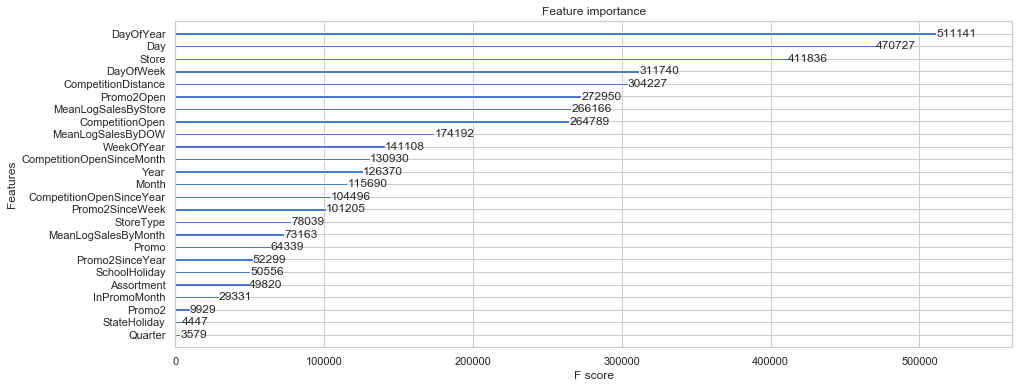

In [6]:
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns

% matplotlib inline

sns.set(style='whitegrid', palette='muted')

m.save_model('data/models/model.joblib.dat')

fig, ax = plt.subplots(figsize=(15, 6))
xgb.plot_importance(m.bst, ax=ax)
plt.show()

### 对测试集进行预测

选择对 _Sales_ 数据的还原缩放权重以修正预处理过程中 _np.log1p_ 可能导致的误差：

Best weight is 1.0, RMSPE is 0.1200


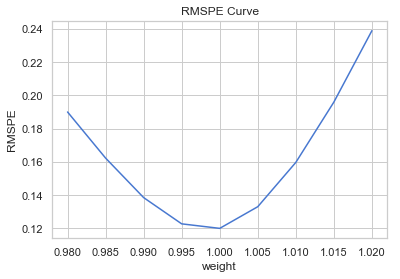

In [10]:
import xgboost as xgb

def correction(model, y_train):
    y_true, y_pred = y_train[:41088], model.bst.predict(xgb.DMatrix(X_train[:41088]))
    weights = np.arange(0.98, 1.02, 0.005)
    errors = []
    
    for w in weights:
        error = cv.rmspe(np.expm1(y_true[:41088]), np.expm1(y_pred * w))
        errors.append(error)

    plt.plot(weights, errors)
    plt.xlabel('weight')
    plt.ylabel('RMSPE')
    plt.title('RMSPE Curve')
    
    idx = errors.index(min(errors))
    print('Best weight is {}, RMSPE is {:.4f}'.format(weights[idx], min(errors)))
    
correction(m, y_train)

生成测试集的预测结果并保存至 CSV 文件：

In [15]:
weight = 1
y_pred = m.predict(X_test, weight=weight)

result = pd.DataFrame({'Id': data_test['Id'], 'Sales': y_pred})
result.to_csv('data/submission.csv', index=False)

### 可视化结果

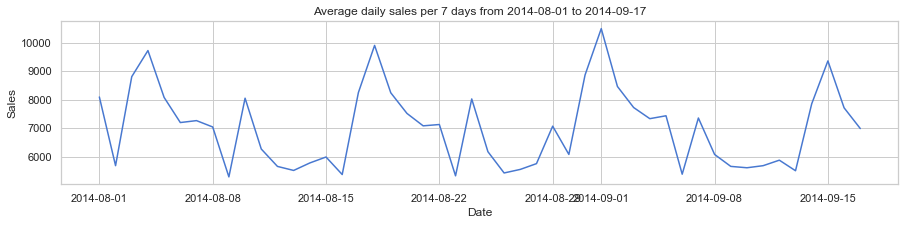

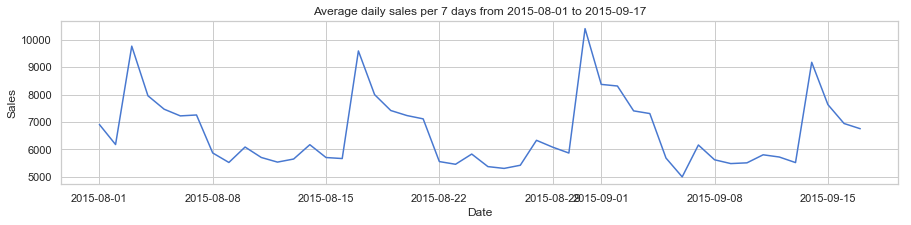

In [16]:
data_train_sales = pd.concat([X_train, np.expm1(y_train * weight)], axis=1)
data_train_sales['Date'] = pd.to_datetime(data_train_sales[['Year', 'Month', 'Day']])
data_train_sales = data_train_sales[(data_train_sales['Date'] >= '2014-08-01') & (data_train_sales['Date'] <= '2014-09-17')]
data_test_sales = pd.concat([X_test, pd.Series(y_pred, name='Sales')], axis=1)
data_test_sales['Date'] = pd.to_datetime(data_test_sales[['Year', 'Month', 'Day']])
data_train_sales_1 = data_train_sales.groupby(pd.Grouper(key='Date', freq='D')).mean()
data_test_sales_1 = data_test_sales.groupby(pd.Grouper(key='Date', freq='D')).mean()

plt.figure(figsize=(15, 3))
sns.lineplot(x=data_train_sales_1.index, y=data_train_sales_1['Sales']).set_title('Average daily sales per 7 days from 2014-08-01 to 2014-09-17')
plt.show()
plt.figure(figsize=(15, 3))
sns.lineplot(x=data_test_sales_1.index, y=data_test_sales_1['Sales']).set_title('Average daily sales per 7 days from 2015-08-01 to 2015-09-17')
plt.show()